# **Projet de fin de formation en data analyse**
## Exploratory data analysis
### 🥘 Etude pour l'implantation d'un nouveau service de livraison de repas en France

> 💡 *Note : pour des raisons d'optimisation, les exports des fichiers nettoyés sont désactivés par defaut, pensez à les activer en décommentant les lignes concernées si necessaire.*

### **Plan du notebook :**
- **Exploration et nettoyage**
    - [Exploration du jeu de données](#partie-1)
    - [Nettoyage et optimisation](#partie-2)
    - [Temporalité du jeu de données](#date)
- **Explorations visuelles et élements d'analyse**
    - [Analyse des commandes](#commandes)
    - [Analyse par concurrent](#concurrent)
    - [Parts de marché et chiffre d'affaire](#market)
    - [Panier moyens](#panier-moyen)
    - [Analyse de la clientèle](#clients)
    - [Observations des corrélations](#corr)
    - [Analyses géographiques](#geo)
    - [Analyse IdF vs reste de la France](#idf)
    - [Analyse des types de nourriture](#food)
    - [Analyse des vendeurs](#sellers)
    - [Analyse des promotions](#promo)
    - [Analyse des frais](#fees)

### **Endpoints des emplacement de fichiers et import des librairies**

In [168]:
# Install necessary libraries
!pip install plotly_calplot

# Import des librairies :
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from difflib import get_close_matches
from plotly_calplot import calplot

> ⚠️ A modifier en fonction de votre configuration :

In [169]:
# Emplacements des fichiers sources et du dossier d'export :
url_transactions = 'http://cgphoto.cluster010.ovh.net/data/bolt_food/transactions.csv'
url_customers = 'http://cgphoto.cluster010.ovh.net/data/bolt_food/customers.csv'
url_products = 'http://cgphoto.cluster010.ovh.net/data/bolt_food/products.csv'
# Emplacement du dossier d'export
# save = ''

# **Exploration et nettoyage**

## <a id="partie-1"></a>Exploration du jeu de données

In [170]:
# Import des données fournies (3 fichiers csv)
df_transactions = pd.read_csv(url_transactions)
df_customers = pd.read_csv(url_customers)
df_products = pd.read_csv(url_products)

In [171]:
# On affiche les 5 premières lignes de chaque dataframe pour regarder comment sont structurées les données
display(df_transactions.head())
display(df_customers.head())
display(df_products.head())

,row_nb,synthetic_gender,synthetic_age_generation,is_loyalty_deliveroo,merchant_name,order_date,order_time,order_total_paid,order_currency,payment_method_name,...,order_total_fees,order_total_promo,seller_name,seller_category_name,order_item_delivery_address_region,order_item_delivery_address_subregion,order_item_delivery_address_city,is_customer_month_ubereats,is_customer_month_justeat,is_customer_month_deliveroo
0,1,2.0,Gen. Y - [1980-1994],NaN,deliveroo,2020-01-15,12:00:00,10.3,eur,NaN,...,0.0,0.0,thai in box,asian - thai,ile de france,hauts de seine,sevres,0,0,1
1,2,1.0,Gen. Z - [1995-2010],NaN,uber eats,2019-01-24,19:00:00,7.6,eur,payment card - visa,...,2.5,5.0,nanbab - villeurbanne,asian - indian,auvergne rhone alpes,rhone,villeurbanne,1,0,1
2,3,1.0,Gen. Z - [1995-2010],NaN,uber eats,2020-02-05,12:00:00,10.6,eur,paypal,...,3.7,0.0,los tacos,latin american - mexican,grand est,meurthe et moselle,maxeville,1,0,0
3,4,1.0,Gen. Y - [1980-1994],NaN,just eat,2019-01-11,21:00:00,0.0,eur,NaN,...,NaN,0.0,NaN,NaN,ile de france,val d oise,cergy,0,1,0
4,5,NaN,Gen. Z - [1995-2010],NaN,deliveroo,2019-12-15,20:00:00,25.3,eur,NaN,...,2.5,4.0,o'tacos,latin american - mexican,ile de france,seine saint denis,aubervilliers,0,0,1


,year_month,merchant_name,order_item_delivery_address_region,count_customers
0,2017-01,deliveroo,idf - paris,544
1,2017-01,deliveroo,idf - rest of idf,121
2,2017-01,deliveroo,other region,636
3,2017-01,just eat,idf - paris,167
4,2017-01,just eat,idf - rest of idf,358


,f0_,id_order,product_name,product_description,merchant_name
0,2017-01-01,AVkmcB3KFSf772cTh6V2M9yGwuQ=,toast goody woody,NaN,deliveroo
1,2017-01-01,CQeMFF72l4u80Ae4mnVLhnTzqx0=,soupe miso,sauce soja,deliveroo
2,2017-01-01,CQeMFF72l4u80Ae4mnVLhnTzqx0=,salmon lovers,"sauce soja sucree, baguettes, sauce soja sucre...",deliveroo
3,2017-01-01,CQeMFF72l4u80Ae4mnVLhnTzqx0=,super mix,any three skewers with lamb & chicken doner se...,deliveroo
4,2017-01-01,CQeMFF72l4u80Ae4mnVLhnTzqx0=,salade de choux,NaN,deliveroo


In [172]:
# On affiche les informations de chaque dataframe pour identifier d'éventuelles valeurs manquantes, problèmes de type de données, etc.
display(df_transactions.info())
display(df_customers.info())
display(df_products.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 807676 entries, 0 to 807675
Data columns (total 22 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   row_nb                                 807676 non-null  int64  
 1   synthetic_gender                       777290 non-null  float64
 2   synthetic_age_generation               757776 non-null  object 
 3   is_loyalty_deliveroo                   29245 non-null   float64
 4   merchant_name                          807676 non-null  object 
 5   order_date                             807676 non-null  object 
 6   order_time                             807676 non-null  object 
 7   order_total_paid                       777469 non-null  float64
 8   order_currency                         807676 non-null  object 
 9   payment_method_name                    442379 non-null  object 
 10  order_delivery_fee                     807477 non-null  

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 4 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   year_month                          378 non-null    object
 1   merchant_name                       378 non-null    object
 2   order_item_delivery_address_region  378 non-null    object
 3   count_customers                     378 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 11.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1711616 entries, 0 to 1711615
Data columns (total 5 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   f0_                  object
 1   id_order             object
 2   product_name         object
 3   product_description  object
 4   merchant_name        object
dtypes: object(5)
memory usage: 65.3+ MB


None

In [173]:
# On regarde le nombre d'observations dans chaque dataframe
print(f'df_transactions contient {df_transactions.shape[0]} observations')
print(f'df_customers contient {df_customers.shape[0]} observations')
print(f'df_products contient {df_products.shape[0]} observations')

df_transactions contient 807676 observations
df_customers contient 378 observations
df_products contient 1711616 observations


In [174]:
# On affiche statistiques descriptives pour chaque dataframe
display(df_transactions.describe())
display(df_customers.describe())
display(df_products.describe())

,row_nb,synthetic_gender,is_loyalty_deliveroo,order_total_paid,order_delivery_fee,order_processing_fee,order_total_fees,order_total_promo,is_customer_month_ubereats,is_customer_month_justeat,is_customer_month_deliveroo
count,807676.000000,777290.000000,29245.000000,777469.000000,807477.000000,807676.000000,703761.000000,807676.000000,807676.000000,807676.000000,807676.000000
mean,403838.500000,1.293762,0.305591,21.283312,2.267897,0.177658,3.608042,0.778346,0.643674,0.173666,0.412890
std,233156.122348,0.455484,0.460665,13.955120,1.392120,0.613622,2.609570,2.737441,0.478913,0.378822,0.492354
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,201919.750000,1.000000,0.000000,13.500000,1.000000,0.000000,2.500000,0.000000,0.000000,0.000000,0.000000
50%,403838.500000,1.000000,0.000000,19.000000,2.500000,0.000000,3.500000,0.000000,1.000000,0.000000,0.000000
75%,605757.250000,2.000000,1.000000,27.900000,3.500000,0.000000,4.200000,0.000000,1.000000,0.000000,1.000000
max,807676.000000,2.000000,1.000000,943.600000,10.200000,21.600000,63.300000,101.900000,1.000000,1.000000,1.000000


,count_customers
count,378.000000
mean,978.140212
std,1039.573762
min,81.000000
25%,396.500000
50%,675.000000
75%,1133.500000
max,7867.000000


,f0_,id_order,product_name,product_description,merchant_name
count,1711616,1711616,1607298,701603,1711616
unique,1277,807731,160427,9770,3
top,2020-06-05,0pmSmXrAizHP73yhfIVqKX8VX/c=,big mac,extra fromage,uber eats
freq,4723,103,30713,33380,1021208


### Visualisation des données en boxplot (valeurs abérantes, outliers, cohérences des données etc...)

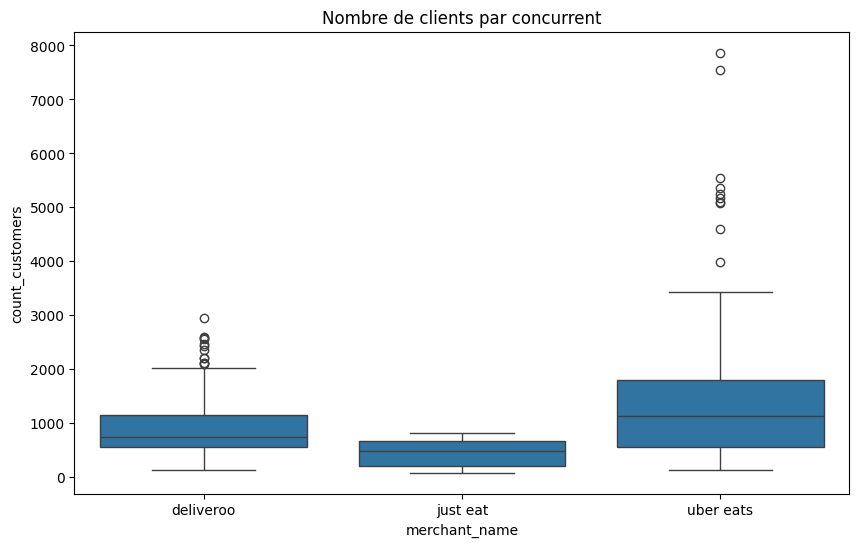

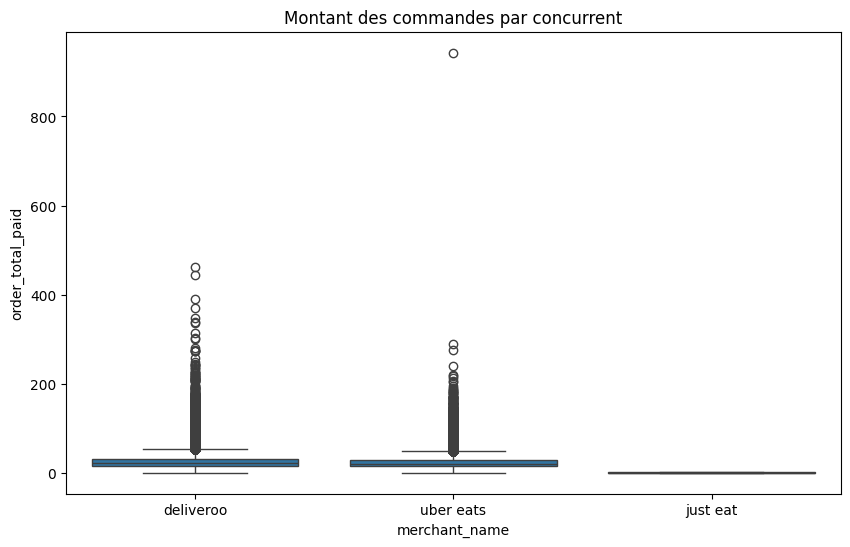

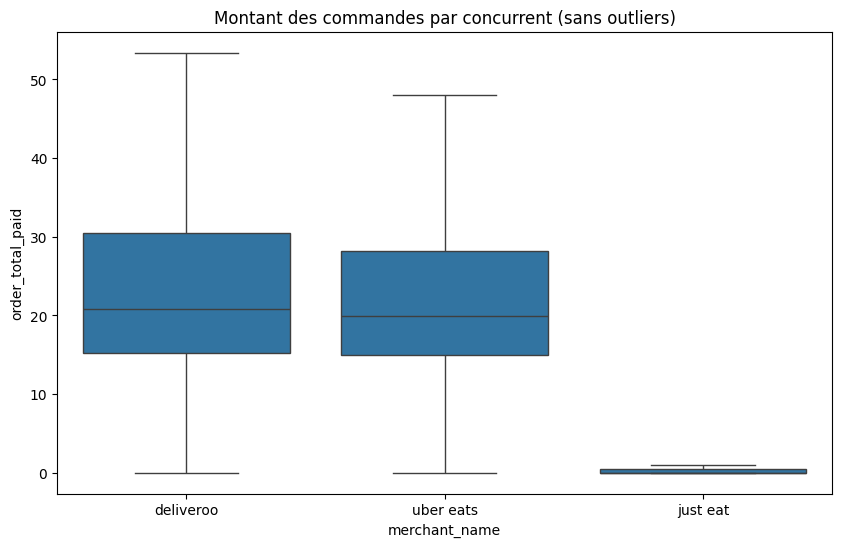

In [175]:
# Boxplot sur les données de df_customers
plt.figure(figsize=(10, 6))
sns.boxplot(x='merchant_name', y='count_customers', data=df_customers)
plt.title('Nombre de clients par concurrent')
plt.show()

# Boxplot sur les données de df_transactions
plt.figure(figsize=(10, 6))
sns.boxplot(x='merchant_name', y='order_total_paid', data=df_transactions)
plt.title('Montant des commandes par concurrent')
plt.show()

# Boxplot sur les données de df_transactions sans les outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='merchant_name', y='order_total_paid', data=df_transactions, showfliers=False)
plt.title('Montant des commandes par concurrent (sans outliers)')
plt.show()

> Il semble que nous n'ayons aucune données financières sur Just Eat

In [176]:
# On regarde les taux de valeurs manquantes pour chaque dataframe
display(df_transactions.isna().sum() / df_transactions.shape[0] * 100)
display(df_customers.isna().sum() / df_customers.shape[0] * 100)
display(df_products.isna().sum() / df_products.shape[0] * 100)

,0
row_nb,0.000000
synthetic_gender,3.762152
synthetic_age_generation,6.178220
is_loyalty_deliveroo,96.379117
merchant_name,0.000000
order_date,0.000000
order_time,0.000000
order_total_paid,3.739990
order_currency,0.000000
payment_method_name,45.228161


,0
year_month,0.0
merchant_name,0.0
order_item_delivery_address_region,0.0
count_customers,0.0


,0
f0_,0.000000
id_order,0.000000
product_name,6.094708
product_description,59.009322
merchant_name,0.000000


<Axes: >

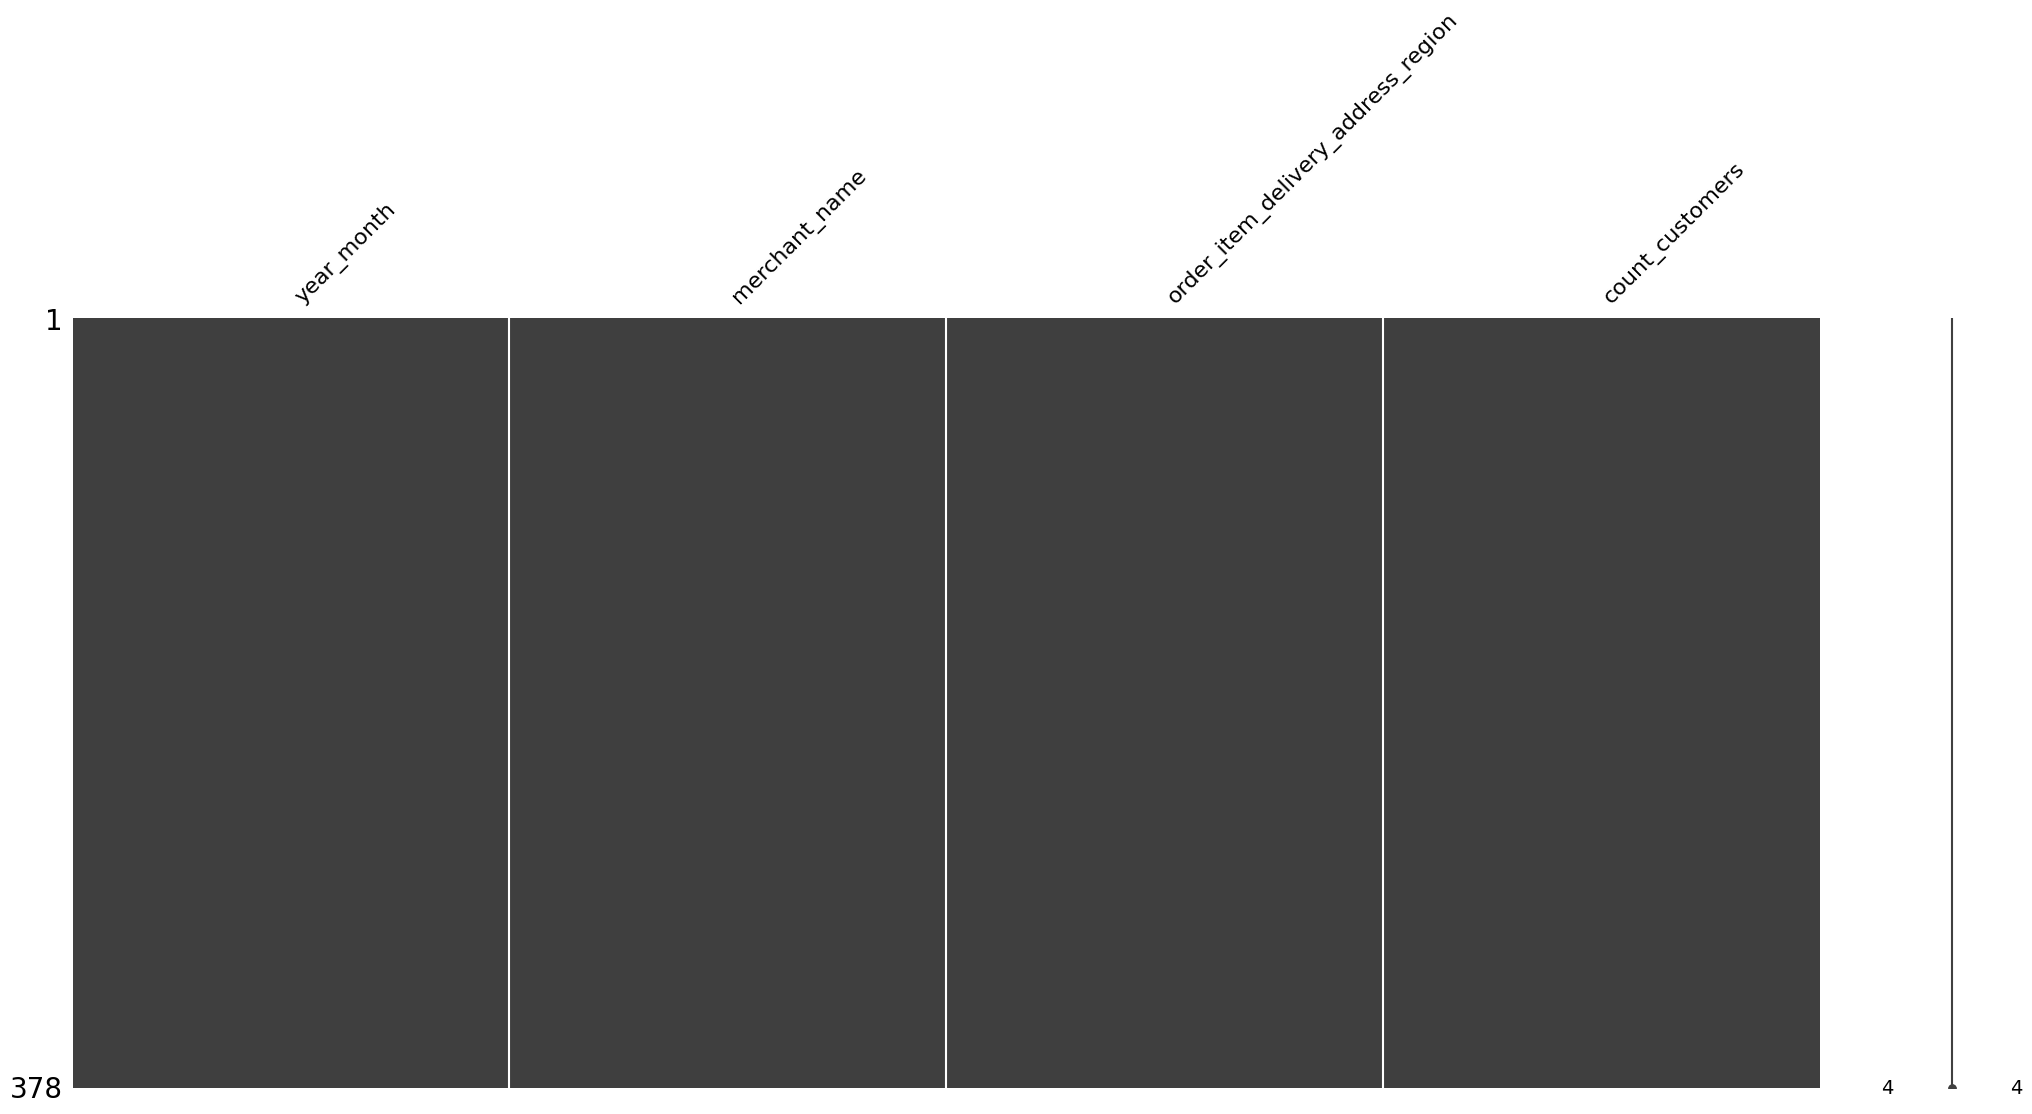

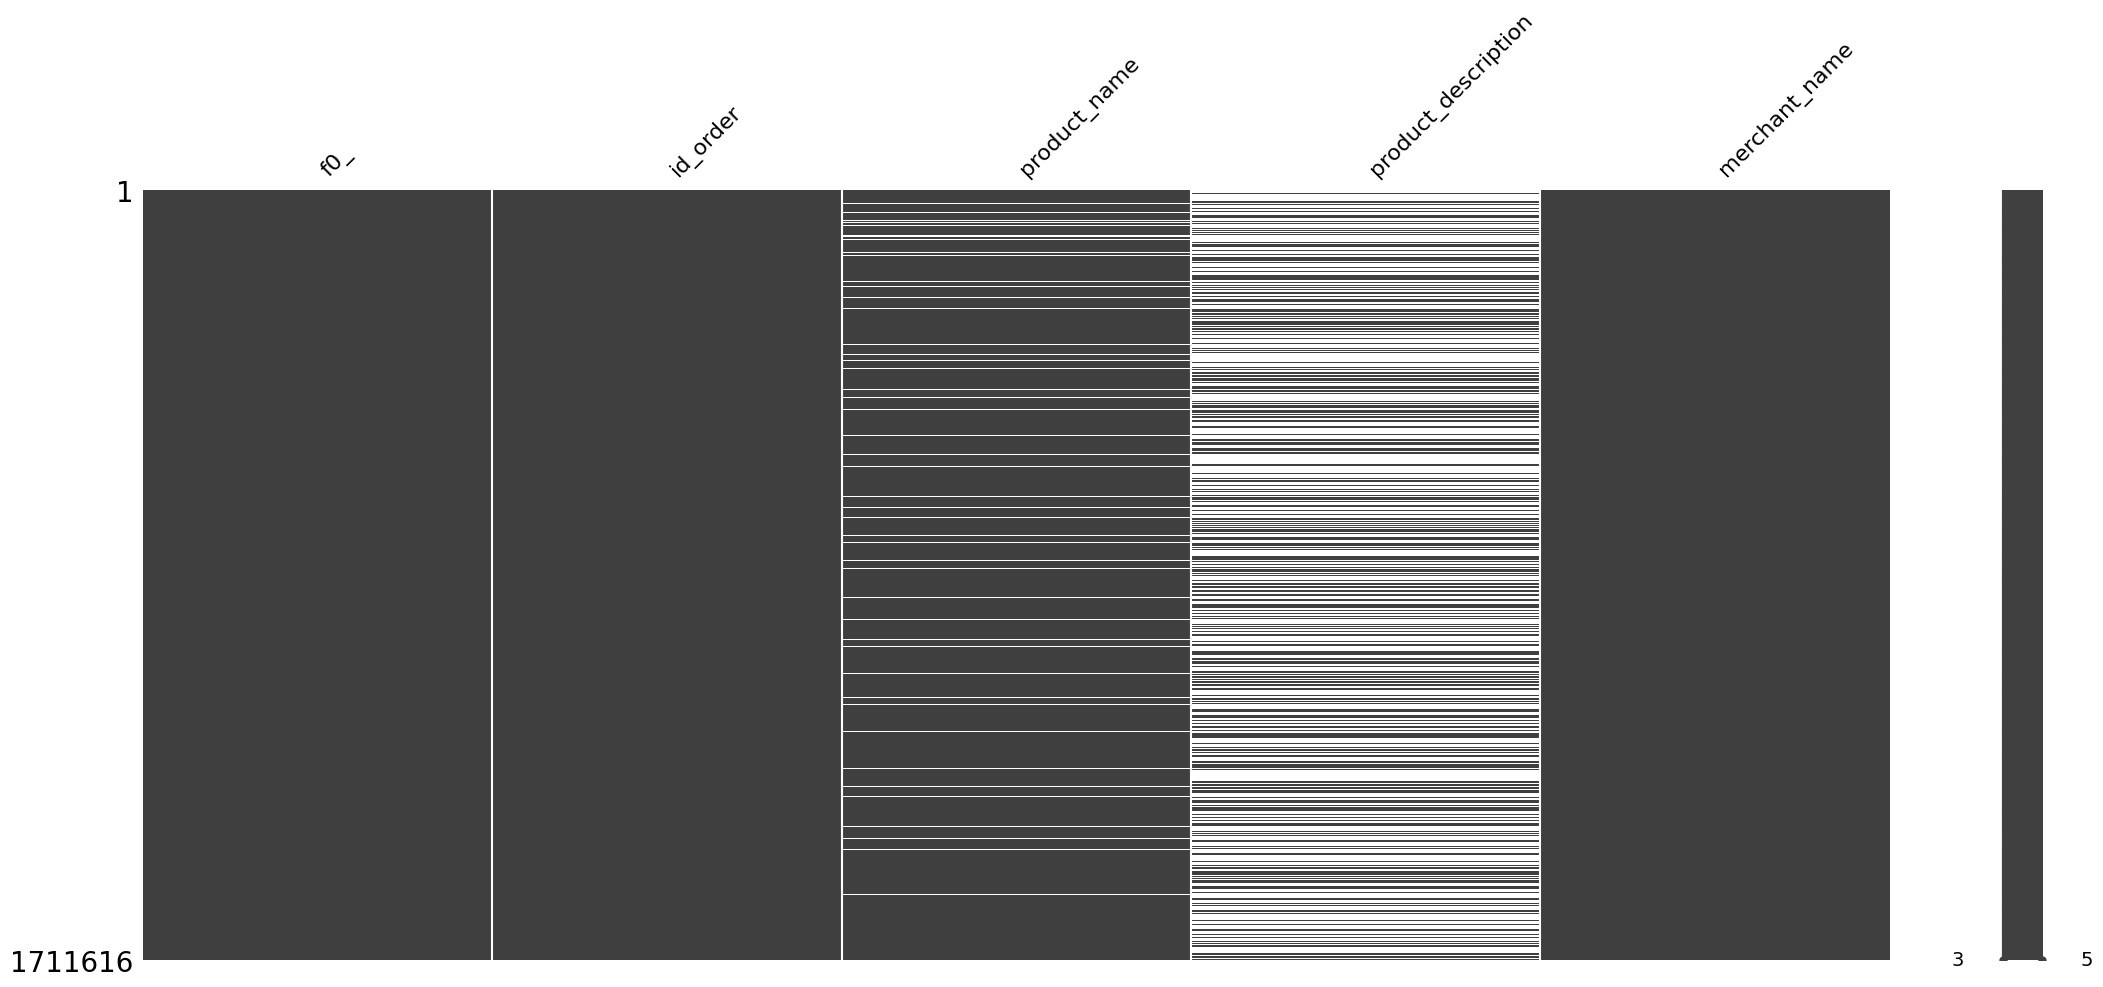

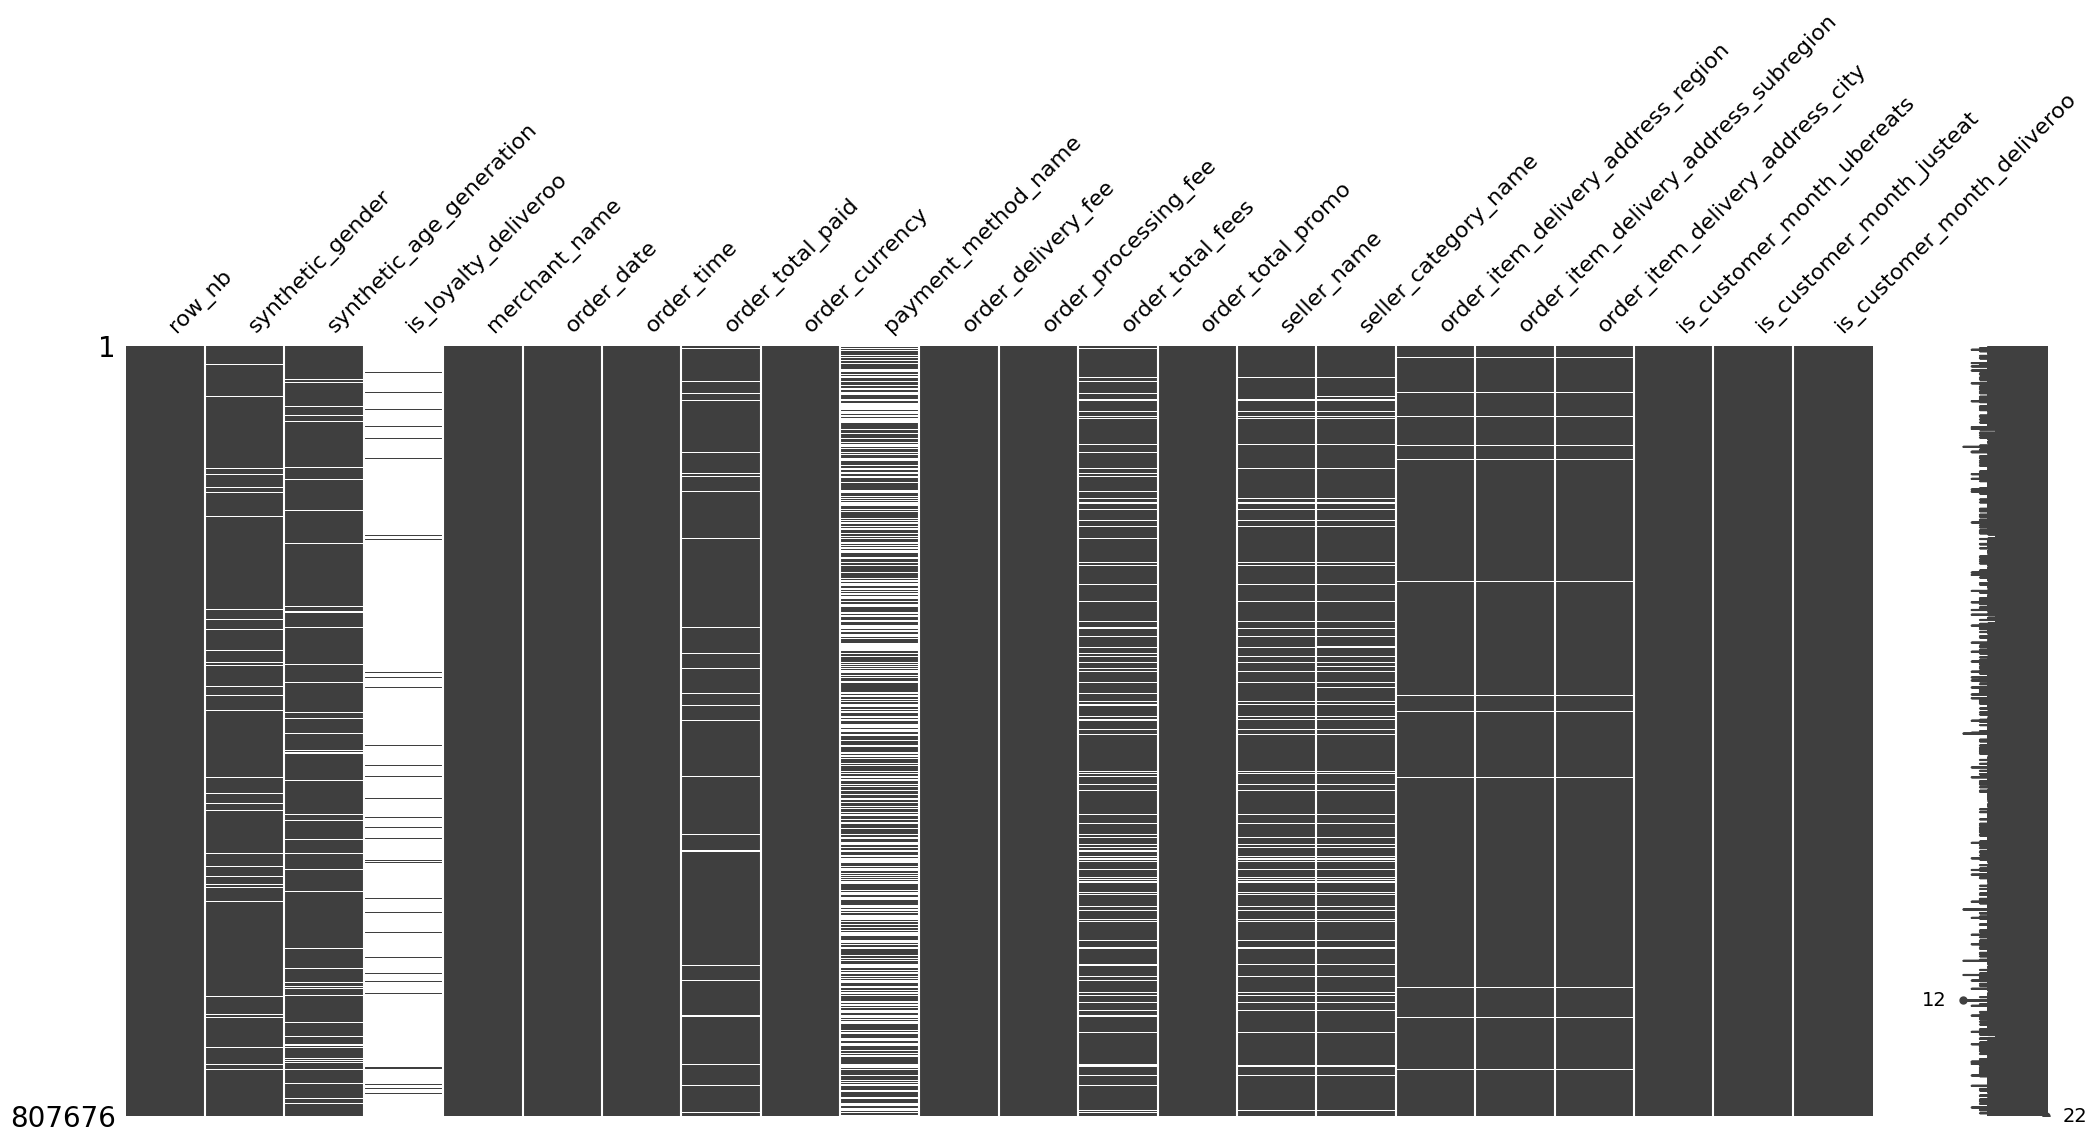

In [177]:
# On visualise les valeurs manquantes avec la librairie missingno
msno.matrix(df_customers)
msno.matrix(df_products)
msno.matrix(df_transactions)

### Conclusion de la 1ere partie de l'exploration :
- Nous avons identifié plusieurs points critiques qui vont demander des modifications.
- [Le détail des modifications à effectuer est disponible ici](https://docs.google.com/spreadsheets/d/1FfCodaz07WdeU7w16DIlZ7NkpT8UBPn5KQBkOXLDfGc/edit?usp=sharing)

## <a id="partie-2"></a>Nettoyage et optimisation
> Observations en détail des informations de chaque fichier du dataset, nettoyage et modifications

### 1. df_customers

In [178]:
# On regarde les types de données de df_customers
df_customers.dtypes

,0
year_month,object
merchant_name,object
order_item_delivery_address_region,object
count_customers,int64


In [179]:
#Nous constatons que le format de 'year_month' n'est pas correct, on le passe en datetime
df_customers['year_month'] = pd.to_datetime(df_customers['year_month'])

In [180]:
# # On exporte le fichier nettoyé en csv
# ######## Décommenter la ligne ci-dessous pour réaliser l'export. #########
# df_customers.to_csv(f'{save}df_customers_clean.csv', index = False)

### 2. df_products

In [181]:
# On regarde les types de données de df_products
df_products.dtypes

,0
f0_,object
id_order,object
product_name,object
product_description,object
merchant_name,object


In [182]:
#'f0_' contient des dates, on le passe en datetime et on la renomme
df_products['f0_'] = pd.to_datetime(df_products['f0_'])
df_products.rename(columns={'f0_': 'date'}, inplace=True)

In [183]:
df_products['date']

,date
0,2017-01-01
1,2017-01-01
2,2017-01-01
3,2017-01-01
4,2017-01-01
...,...
1711611,2020-06-30
1711612,2020-06-30
1711613,2020-06-30
1711614,2020-06-30


In [184]:
# On constate que les données de 'product_description' et 'product_name' sont difficilement exploitables à ce stade, on supprime ces colonnes.
df_products.drop(columns = 'product_description', inplace = True)
df_products.drop(columns = 'product_name', inplace = True)

In [185]:
# A ces stade nous conservons 'id_order' pour identifier plus tard le nombre de commandes et le nombre de produits vendus par commande
# On exporte le fichier nettoyé en csv
######### Décommenter la ligne ci-dessous pour réaliser l'export. #########
# df_products.to_csv(f'{save}df_products_clean.csv', index = False)

### 3. df_transactions

In [186]:
# On regarde les types de données de df_transactions
df_transactions.dtypes

,0
row_nb,int64
synthetic_gender,float64
synthetic_age_generation,object
is_loyalty_deliveroo,float64
merchant_name,object
order_date,object
order_time,object
order_total_paid,float64
order_currency,object
payment_method_name,object


In [187]:
# La colonne 'row_numer' n'est pas utile, on la supprime
df_transactions.drop(columns = 'row_nb', inplace = True)

In [188]:
# La colonne syntetic_gender contient des données décimales, on remplace les valeurs en 'male' ou 'female' ou 'nc' (NaN remplacé par 0).
df_transactions['synthetic_gender'] = df_transactions['synthetic_gender'].fillna(0)
df_transactions['synthetic_gender'] = df_transactions['synthetic_gender'].replace({1: 'male', 2: 'female', 0: 'nc'})

In [189]:
# On remplace les valeurs manquantes de 'synthetic_age_generation' par 'nc'
df_transactions['synthetic_age_generation'] = df_transactions['synthetic_age_generation'].fillna('nc')

In [190]:
# La colonne 'is_loyalty_deliveroo' contient trop de NaN, on la supprime
df_transactions.drop(columns = 'is_loyalty_deliveroo', inplace = True)

In [191]:
# Nous avons deux colonnes de date et heure, nous les fusionnons en une seule colonne 'order_datetime' et nous la passons en datetime
df_transactions['order_datetime'] = pd.to_datetime(df_transactions['order_date'] + ' ' + df_transactions['order_time'])
df_transactions.drop(columns=['order_date', 'order_time'], inplace=True)

In [192]:
# Toutes les transactions sont en euros, on supprime donc la colonne 'order_currency'
df_transactions.drop(columns=['order_currency'], inplace=True)

In [193]:
# La colonne 'payment_method_name' contient des valeurs manquantes, eronnées, des chaines de caraxctères et balises HTML, on la netoie :
df_transactions['payment_method_name'] = df_transactions['payment_method_name'].replace(['imgjoulet3', 'payment card - ', '_card_icon', 'imgjoulet1', 'imgjoulet2', 'imgjoulet4'], '', regex=True)
df_transactions['payment_method_name'] = df_transactions['payment_method_name'].replace(['unavailable_asset', 'default', 'undefined'], 'nc')
df_transactions['payment_method_name'] = df_transactions['payment_method_name'].replace({'pinless_bin': 'payment_card', 'pinless': 'payment card'})

# On split mainentant la colonne en deux colonnes 'payment_method_name_primary' et 'payment_method_name_secondary'
split_columns = df_transactions['payment_method_name'].str.split(';', expand=True)
split_columns = split_columns.reindex(columns=[0, 1], fill_value=None)
df_transactions[['payment_method_name_primary', 'payment_method_name_secondary']] = split_columns
df_transactions.fillna({'payment_method_name_primary': 'nc'}, inplace=True)
df_transactions.fillna({'payment_method_name_secondary': 'nc'}, inplace=True)

# On peut désormais supprimer la colonne 'payment_method_name'
df_transactions.drop(columns=['payment_method_name'], inplace=True)

In [194]:
# On remplace les valeurs manquantes dans 'seller_name' par 'nc'
df_transactions.fillna({'seller_name': 'nc'}, inplace=True)

#### Nettoyage des données de type de produits

In [195]:
# On split la colonne 'seller_category_name' en trois colonnes 'continent_food', 'type_food' et 'subtype_food' pour effectuer des analyses plus détaillées
split_columns_food = df_transactions['seller_category_name'].str.split(' - ', expand=True)
split_columns = split_columns.reindex(columns=[0, 1], fill_value=None)
df_transactions[['continent_food','type_food','subtype_food']] = split_columns_food

# On supprime les valeurs manquantes (remplacées par 'nc')
df_transactions.fillna({'continent_food': 'nc'}, inplace=True)
df_transactions.fillna({'type_food': 'nc'}, inplace=True)
df_transactions.fillna({'subtype_food': 'nc'}, inplace=True)

#### Nettoyage des données géographiques et en particulier 'order_item_delivery_address_subregion' (ajout des numéros de départements)
> Pour la suite de l'analyse nous allons creer un nouvelle colonne 'Numero_Departement' à partir de 'order_item_delivery_address_subregion' grâce à la bibliothèque difflib.

In [196]:
# On supprime les Nans de 'order_item_delivery_address_region' et 'order_item_delivery_address_subregion' et 'order_item_delivery_address_city'
df_transactions.fillna({'order_item_delivery_address_region' : 'nc'}, inplace=True)
df_transactions.fillna({'order_item_delivery_address_subregion': 'nc'}, inplace=True)
df_transactions.fillna({'order_item_delivery_address_city' : 'nc'}, inplace=True)

In [197]:
# On nettoie les noms de départements
df_transactions['order_item_delivery_address_region'] = df_transactions['order_item_delivery_address_region'].str.title().str.replace(' ', '-')
df_transactions['order_item_delivery_address_subregion'] = df_transactions['order_item_delivery_address_subregion'].str.title().str.replace(' ', '-')
df_transactions['order_item_delivery_address_city'] = df_transactions['order_item_delivery_address_city'].str.title().str.replace(' ', '-')

In [198]:
# Pour la suite de l'analyse nous allons creer un nouvelle colonne 'Numero_Departement' à partir de 'order_item_delivery_address_subregion' avec la librairie difflib (get_close_matches)

# On utilise ce dictionnaire des départements français (nom -> numéro)
departements_inverses = {
    "Ain": "01",
    "Aisne": "02",
    "Allier": "03",
    "Alpes-de-Haute-Provence": "04",
    "Hautes-Alpes": "05",
    "Alpes-Maritimes": "06",
    "Ardèche": "07",
    "Ardennes": "08",
    "Ariège": "09",
    "Aube": "10",
    "Aude": "11",
    "Aveyron": "12",
    "Bouches-du-Rhône": "13",
    "Calvados": "14",
    "Cantal": "15",
    "Charente": "16",
    "Charente-Maritime": "17",
    "Cher": "18",
    "Corrèze": "19",
    "Corse-du-Sud": "2A",
    "Haute-Corse": "2B",
    "Côte-D-Or": "21",
    "Côtes-d'Armor": "22",
    "Creuse": "23",
    "Dordogne": "24",
    "Doubs": "25",
    "Drôme": "26",
    "Eure": "27",
    "Eure-et-Loir": "28",
    "Finistère": "29",
    "Gard": "30",
    "Haute-Garonne": "31",
    "Gers": "32",
    "Gironde": "33",
    "Hérault": "34",
    "Ille-et-Vilaine": "35",
    "Indre": "36",
    "Indre-et-Loire": "37",
    "Isère": "38",
    "Jura": "39",
    "Landes": "40",
    "Loir-et-Cher": "41",
    "Loire": "42",
    "Haute-Loire": "43",
    "Loire-Atlantique": "44",
    "Loiret": "45",
    "Lot": "46",
    "Lot-et-Garonne": "47",
    "Lozère": "48",
    "Maine-et-Loire": "49",
    "Manche": "50",
    "Marne": "51",
    "Haute-Marne": "52",
    "Mayenne": "53",
    "Meurthe-et-Moselle": "54",
    "Meuse": "55",
    "Morbihan": "56",
    "Moselle": "57",
    "Nièvre": "58",
    "Nord": "59",
    "Oise": "60",
    "Orne": "61",
    "Pas-de-Calais": "62",
    "Puy-de-Dôme": "63",
    "Pyrénées-Atlantiques": "64",
    "Hautes-Pyrénées": "65",
    "Pyrénées-Orientales": "66",
    "Bas-Rhin": "67",
    "Haut-Rhin": "68",
    "Rhône": "69",
    "Haute-Saône": "70",
    "Saône-et-Loire": "71",
    "Sarthe": "72",
    "Savoie": "73",
    "Haute-Savoie": "74",
    "Paris": "75",
    "Seine-Maritime": "76",
    "Seine-et-Marne": "77",
    "Yvelines": "78",
    "Deux-Sèvres": "79",
    "Somme": "80",
    "Tarn": "81",
    "Tarn-et-Garonne": "82",
    "Var": "83",
    "Vaucluse": "84",
    "Vendée": "85",
    "Vienne": "86",
    "Haute-Vienne": "87",
    "Vosges": "88",
    "Yonne": "89",
    "Territoire de Belfort": "90",
    "Essonne": "91",
    "Hauts-de-Seine": "92",
    "Seine-Saint-Denis": "93",
    "Val-de-Marne": "94",
    "Val-d'Oise": "95",
    "Guadeloupe": "971",
    "Martinique": "972",
    "Guyane": "973",
    "La Réunion": "974",
    "Mayotte": "976"
}

# Que l'on vient comparer à notre liste de départements
liste_departements = df_transactions['order_item_delivery_address_subregion']

# Et on recherche les correspondances
correspondances = {}
for dep in tqdm(liste_departements, desc="Processing departments numbers matching"):
    normalized_dep = dep.replace("-", " ").title()
    match = get_close_matches(normalized_dep, departements_inverses.keys(), n=1)
    if match:
        correspondances[dep] = departements_inverses[match[0]]
    else:
        correspondances[dep] = None

# Puis on ajoute une colonne avec le numéro de département correspondant
df_transactions["departement_number"] = df_transactions['order_item_delivery_address_subregion'].map(correspondances)

Processing departments numbers matching: 100%|██████████| 807676/807676 [06:27<00:00, 2082.74it/s]


In [199]:
# On remplace les valeurs manquantes par 'nc'
df_transactions.fillna({'departement_number': 'nc'}, inplace=True)
df_transactions.fillna({'order_item_delivery_address_subregion': 'nc'}, inplace=True)

In [200]:
# On constate que nous avons quelques zones géographioques à l'étranger dans 'order_item_delivery_address_subregion', on les supprime car l'analyse ne concerne que la France
df_transactions = df_transactions[~df_transactions['order_item_delivery_address_subregion'].isin(['Barcelona', 'Las-Palmas', 'London'])]

In [201]:
# On verifie que nous avons bien le même nombre de départements et de numéros de départements.
if df_transactions['order_item_delivery_address_subregion'].nunique() == df_transactions['departement_number'].nunique():
    print(f"OK : Nous avons {df_transactions['order_item_delivery_address_subregion'].nunique()} départements différentes et {df_transactions['departement_number'].nunique()} numéros de départements différents")
else:
    print("ERREUR : Nous n'avons pas le même nombre de départements et de numéros de départements")

OK : Nous avons 95 départements différentes et 95 numéros de départements différents


#### Nettoyage des données financières
1. Nous avons constaté que nous n'avions pas de données financières pour Just Eat.
> Les commandes Just Eat semblent s'arrêter avec des missing values.
2. Nous constatons que nous avons des montants négatifs dans 'order_total_paid'. Cela s'explique par le fait que le total n'inclut pas les réductions. Nous recréons donc une colonne 'order_total' pour les intégrer.
2. Le total des fees est également erroné. Nous recalculons la colonne.

In [202]:
# Ajout de la colonne 'order_total' (somme de 'order_total_paid' et 'order_total_promo')
df_transactions['order_total'] = df_transactions['order_total_paid'] + df_transactions['order_total_promo']

In [203]:
# On vérifie que tous les Nans de 'order_total' correspondent à des commandes Just Eat
df_transactions['order_total'].isna().sum() == df_transactions[df_transactions['merchant_name'] == 'just eat']['order_total'].isna().sum()

True

In [204]:
# On regarder la temporalité des valeurs manquantes pour Just Eat
missing_just_eat = df_transactions[(df_transactions['order_total'].isna()) & (df_transactions['merchant_name'] == 'just eat')]

In [205]:
# Nous supprimons donc les données de Just Eat sur la plage de date identifiée du dataframe
df_transactions = df_transactions[~((df_transactions['merchant_name'] == 'just eat') & (df_transactions['order_datetime'] >= '2019-06-20'))]

In [206]:
# Ajout d'une nouvelle colonne du total des frais
df_transactions['total_fees'] = df_transactions['order_delivery_fee'] + df_transactions['order_processing_fee']

<ipython-input-206-1aaed3e4088a>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Promotions
Nous pouvons regarder de plus prêt les promotions :
- Le client a t-il bénéficié d'une promotion ?
- Si oui, quelle était la valeur de la remise en % ?

In [207]:
# Nous ajoutons une colonne 'is_promo' pour identifier si le client a bénéficié d'une promotion
df_transactions['is_promo'] = df_transactions['order_total_promo'] > 0

<ipython-input-207-09332825bb13>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [208]:
# Nous calculons le pourcentage de la promotion par rapport au total de la commande
df_transactions['pourcentage_promo'] = round(df_transactions['order_total_promo'] / df_transactions['order_total'] * 100,2)

<ipython-input-208-400e80c2599f>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Réagencement des colonnes et export du 'df_transactions'.

In [209]:
df_transactions.drop(columns=['order_total_paid', 'order_total_fees', 'seller_category_name'], inplace=True)

In [210]:
df_transactions.columns

Index(['synthetic_gender', 'synthetic_age_generation', 'merchant_name',
       'order_delivery_fee', 'order_processing_fee', 'order_total_promo',
       'seller_name', 'order_item_delivery_address_region',
       'order_item_delivery_address_subregion',
       'order_item_delivery_address_city', 'is_customer_month_ubereats',
       'is_customer_month_justeat', 'is_customer_month_deliveroo',
       'order_datetime', 'payment_method_name_primary',
       'payment_method_name_secondary', 'continent_food', 'type_food',
       'subtype_food', 'departement_number', 'order_total', 'total_fees',
       'is_promo', 'pourcentage_promo'],
      dtype='object')

In [211]:
# On réordonne les colonnes pour plus de clarté
df_transactions = df_transactions.reindex(columns = [   'order_datetime',
                                                        'synthetic_gender',
                                                        'synthetic_age_generation',
                                                        'seller_name',
                                                        'merchant_name',
                                                        'order_total',
                                                        'order_total_promo',
                                                        'order_delivery_fee',
                                                        'order_processing_fee',
                                                        'total_fees',
                                                        'is_promo',
                                                        'pourcentage_promo',
                                                        'payment_method_name_primary',
                                                        'payment_method_name_secondary',
                                                        'order_item_delivery_address_region',
                                                        'order_item_delivery_address_subregion',
                                                        'departement_number',
                                                        'order_item_delivery_address_city',
                                                        'is_customer_month_ubereats',
                                                        'is_customer_month_justeat',
                                                        'is_customer_month_deliveroo',
                                                        'continent_food',
                                                        'type_food',
                                                        'subtype_food',
                                                        ])

In [212]:
# Nous créons un nouveau dataframe spécifique sans les donnée de Just Eat pour l'analyse financière nottament :
df_transactions_no_just_eat = df_transactions[df_transactions['merchant_name'] != 'just eat']

In [213]:
# On exporte le fichier nettoyé en csv
######### Décommenter la ligne ci-dessous pour réaliser l'export. #########
#df_transactions.to_csv(f'{save}df_transactions_clean.csv', index = False)

## <a id="date"></a>Temporalité du jeu de données

In [214]:
# Vérification de la cohérence des dates entre les trois dataframes :
print(f"Le dataframe 'customers' s'étend du {df_customers['year_month'].min()} au {df_customers['year_month'].max()}")
print(f"Le dataframe 'products' s'étend du {df_products['date'].min()} au {df_products['date'].max()}")
print(f"Le dataframe 'transactions' s'étend du {df_transactions['order_datetime'].min()} au {df_transactions['order_datetime'].max()}")

# On regarder la temporalité des valeurs manquantes pour Just Eat
min = missing_just_eat['order_datetime'].min()
max = missing_just_eat['order_datetime'].max()
print(f'Les valeurs manquantes de Just Eat commencent le {min}...et se terminent le {max}')

Le dataframe 'customers' s'étend du 2017-01-01 00:00:00 au 2020-06-01 00:00:00
Le dataframe 'products' s'étend du 2017-01-01 00:00:00 au 2020-06-30 00:00:00
Le dataframe 'transactions' s'étend du 2017-01-01 00:00:00 au 2020-06-30 23:00:00
Les valeurs manquantes de Just Eat commencent le 2019-06-20 00:00:00...et se terminent le 2020-06-30 23:00:00


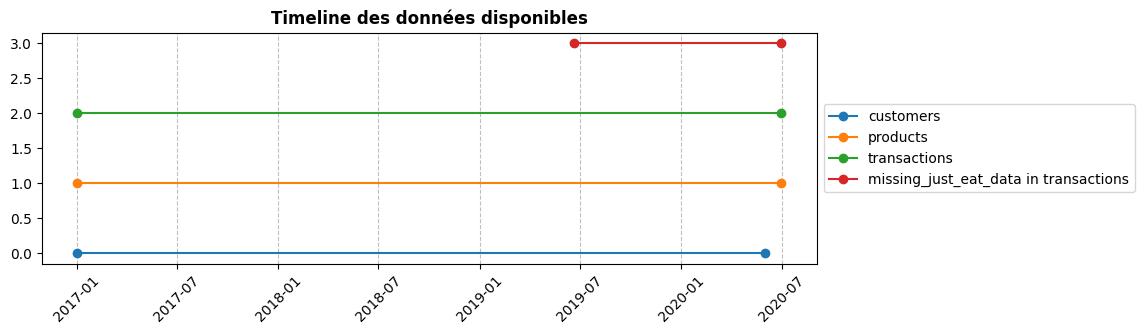

In [215]:
# Timeline des dataframes
import matplotlib.dates as mdates

# Définition des variables
datasets = ['customers', 'products', 'transactions', 'missing_just_eat_data in transactions']
start_dates = [df_customers['year_month'].min(), df_products['date'].min(), df_transactions['order_datetime'].min(), '2019-06-20 00:00:00']
end_dates = [df_customers['year_month'].max(), df_products['date'].max(), df_transactions['order_datetime'].max(), '2020-06-30 23:00:00']

# Conversion des dates en format datetime
start_dates_dt = pd.to_datetime(start_dates)
end_dates_dt = pd.to_datetime(end_dates)

# Positions sur l'axe y pour chaque dataset
y_positions = range(len(datasets))

# Création de la timeline
plt.figure(figsize=(10, 3))
for i, (start, end) in enumerate(zip(start_dates_dt, end_dates_dt)):
    plt.plot([start, end], [y_positions[i], y_positions[i]], marker='o', label=datasets[i])
plt.xticks(rotation=45)
plt.title("Timeline des données disponibles", fontsize=12, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.8)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

# **Explorations visuelles et élements d'analyse**

In [216]:
# Definition des palettes de couleurs pour les différents graphiques
palette = {'uber eats': '#048748', 'deliveroo': '#18bda9', 'just eat': '#f77c00', 'panier moyen global' : '#2020df'}
palette_genre = {'male': '#029ef6', 'female': '#e547a1', 'nc': 'grey'}
palette_geo = sns.color_palette("Paired")

### <a id="commandes"></a>Analyse des commandes

Text(0.5, 1.0, 'Nombre de commandes par mois')

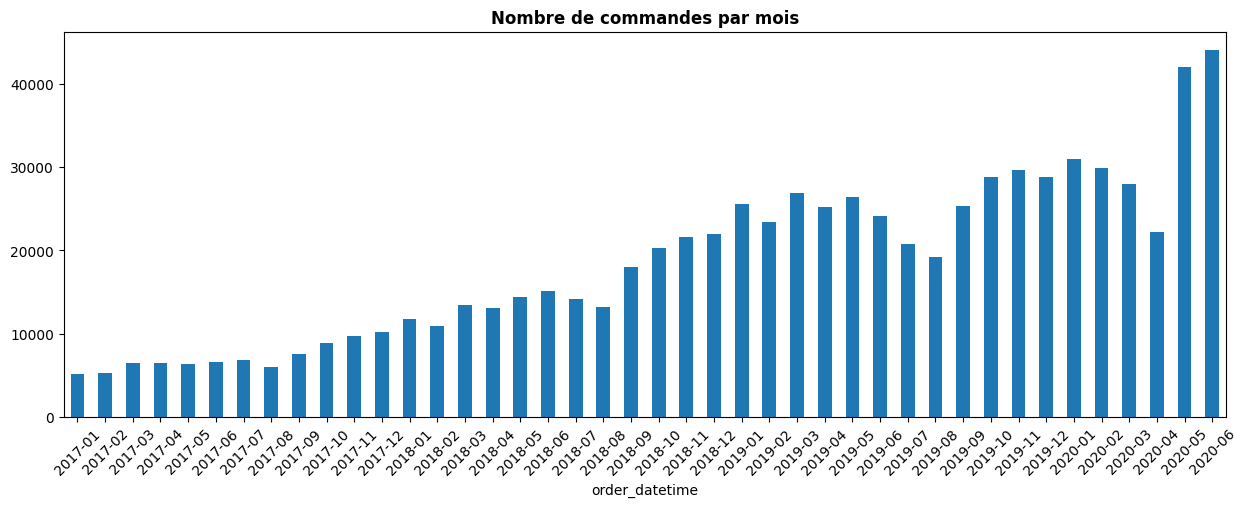

In [217]:
# Nombre de commandes par périodes
df_transactions['order_datetime'].dt.to_period("M").value_counts().sort_index().plot(kind='bar', figsize=(15,5))
plt.xticks(rotation=45)
plt.show
plt.title('Nombre de commandes par mois', fontsize=12, fontweight='bold')

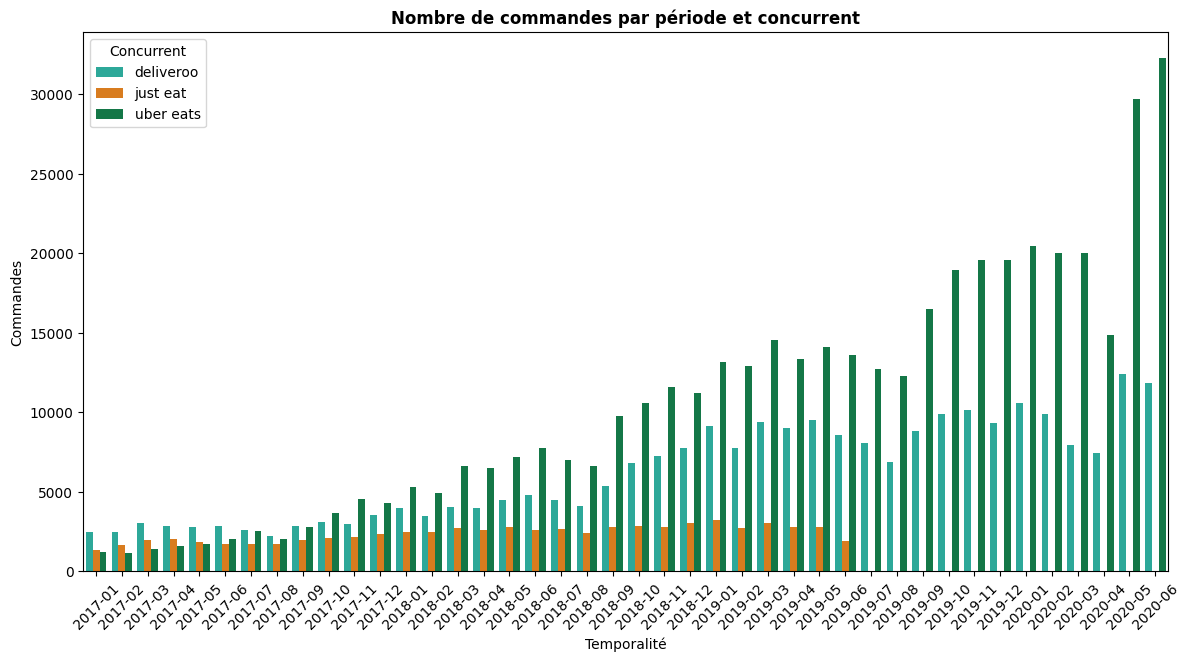

In [218]:
# Nombre de commandes par périodes et par concurrents
df_transactions['period'] = df_transactions['order_datetime'].dt.to_period("M")
commandes = df_transactions.groupby('period')["merchant_name"].value_counts().to_frame().reset_index()
plt.figure(figsize=(14, 7))
sns.barplot(y=commandes['count'], x=commandes['period'], hue=commandes['merchant_name'], errorbar=None, palette=palette)
plt.ylabel('Commandes')
plt.xlabel('Temporalité')
plt.title('Nombre de commandes par période et concurrent', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title='Concurrent')
plt.show()

In [219]:
# Chiffre d'affaire par mois
ca_month = df_transactions.groupby(df_transactions['order_datetime'].dt.month_name())['order_total'].sum().reset_index().rename(columns={'order_datetime': 'month', 'order_total': 'ca'})
ca_month = ca_month.set_index('month').reindex(['January',
                                                            'February',
                                                            'March',
                                                            'April',
                                                            'May',
                                                            'June',
                                                            'July',
                                                            'August',
                                                            'September',
                                                            'October',
                                                            'November',
                                                            'December']).reset_index()
ca_month['month'] = ca_month['month'].replace({
                                                    'January': 'Janvier',
                                                    'February': 'Février',
                                                    'March': 'Mars',
                                                    'April': 'Avril',
                                                    'May': 'Mai',
                                                    'June': 'Juin',
                                                    'July': 'Juillet',
                                                    'August': 'Aout',
                                                    'September': 'Septembre',
                                                    'October' : 'Octobre',
                                                    'November': 'Novembre',
                                                    'December': 'Décembre'
                                                    })
display(ca_month)

,month,ca
0,Janvier,1586121.9
1,Février,1503434.0
2,Mars,1605813.1
3,Avril,1514749.6
4,Mai,2159220.4
5,Juin,2115219.2
6,Juillet,895991.3
7,Aout,822841.2
8,Septembre,1084264.4
9,Octobre,1249547.0


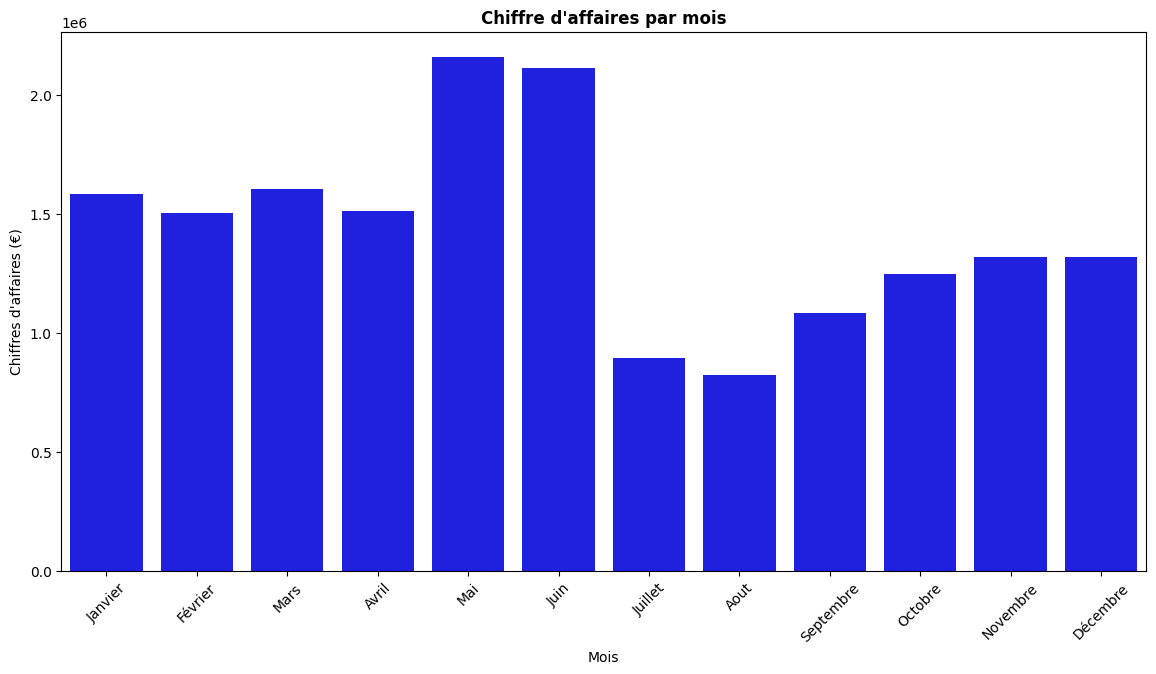

In [220]:
plt.figure(figsize=(14, 7))
sns.barplot(data=ca_month, x='month', y='ca', color='blue')
plt.title('Chiffre d\'affaires par mois', fontsize=12, fontweight='bold')
plt.ylabel('Chiffres d\'affaires (€)')
plt.xlabel('Mois')
plt.xticks(rotation=45)
plt.show()

In [221]:
# Nombre de commandes par jour de la semaine
commandes_day_week = df_transactions.groupby(df_transactions['order_datetime'].dt.day_name())['merchant_name'].count().reset_index().rename(columns={'order_datetime': 'day_of_week', 'merchant_name': 'orders'})
commandes_day_week = commandes_day_week.set_index('day_of_week').reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()
commandes_day_week['day_of_week'] = commandes_day_week['day_of_week'].replace({
    'Monday': 'Lundi',
    'Tuesday': 'Mardi',
    'Wednesday': 'Mercredi',
    'Thursday': 'Jeudi',
    'Friday': 'Vendredi',
    'Saturday': 'Samedi',
    'Sunday': 'Dimanche'
})
display(commandes_day_week)

,day_of_week,orders
0,Lundi,95192
1,Mardi,97939
2,Mercredi,103307
3,Jeudi,106943
4,Vendredi,119348
5,Samedi,114856
6,Dimanche,137412


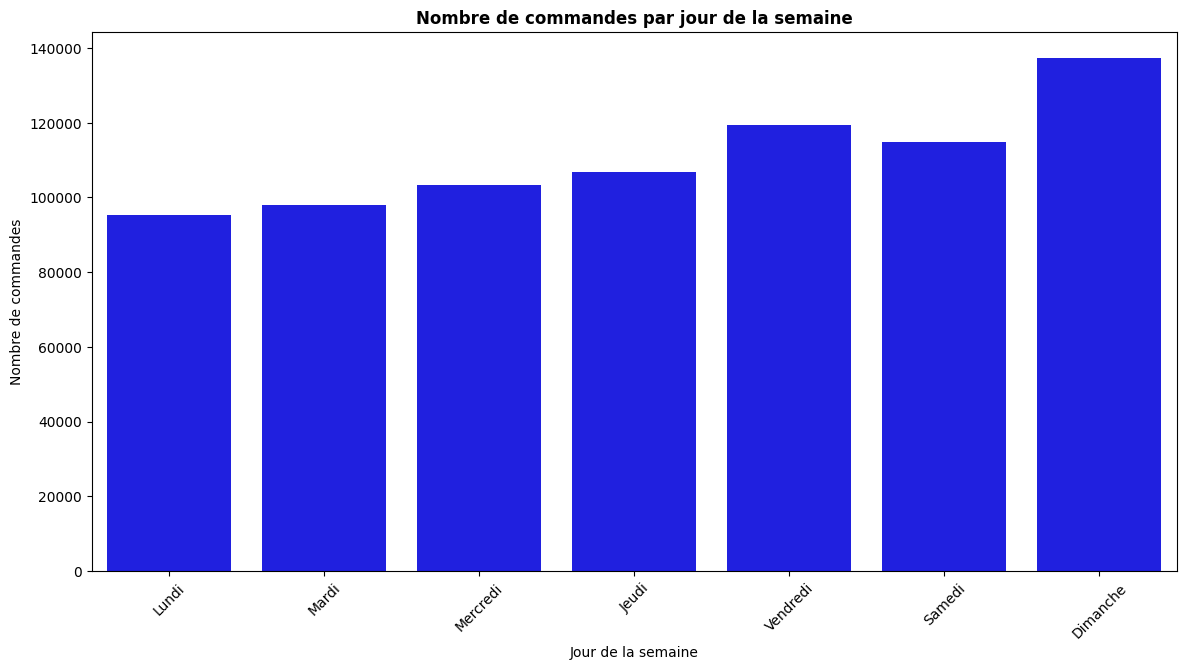

In [222]:
plt.figure(figsize=(14, 7))
sns.barplot(data=commandes_day_week, x='day_of_week', y='orders', color='blue')
plt.title('Nombre de commandes par jour de la semaine', fontsize=12, fontweight='bold')
plt.ylabel('Nombre de commandes')
plt.xlabel('Jour de la semaine')
plt.xticks(rotation=45)
plt.show()

In [223]:
# Nombre de commandes par heure
commandes_hours = df_transactions.groupby(df_transactions['order_datetime'].dt.time)['merchant_name'].count().reset_index().rename(columns={'order_datetime': 'hour', 'merchant_name': 'orders'})
commandes_hours

,hour,orders
0,00:00:00,24850
1,01:00:00,11581
2,02:00:00,6074
3,03:00:00,3510
4,04:00:00,1945
5,05:00:00,1154
6,06:00:00,668
7,07:00:00,454
8,08:00:00,641
9,09:00:00,1497


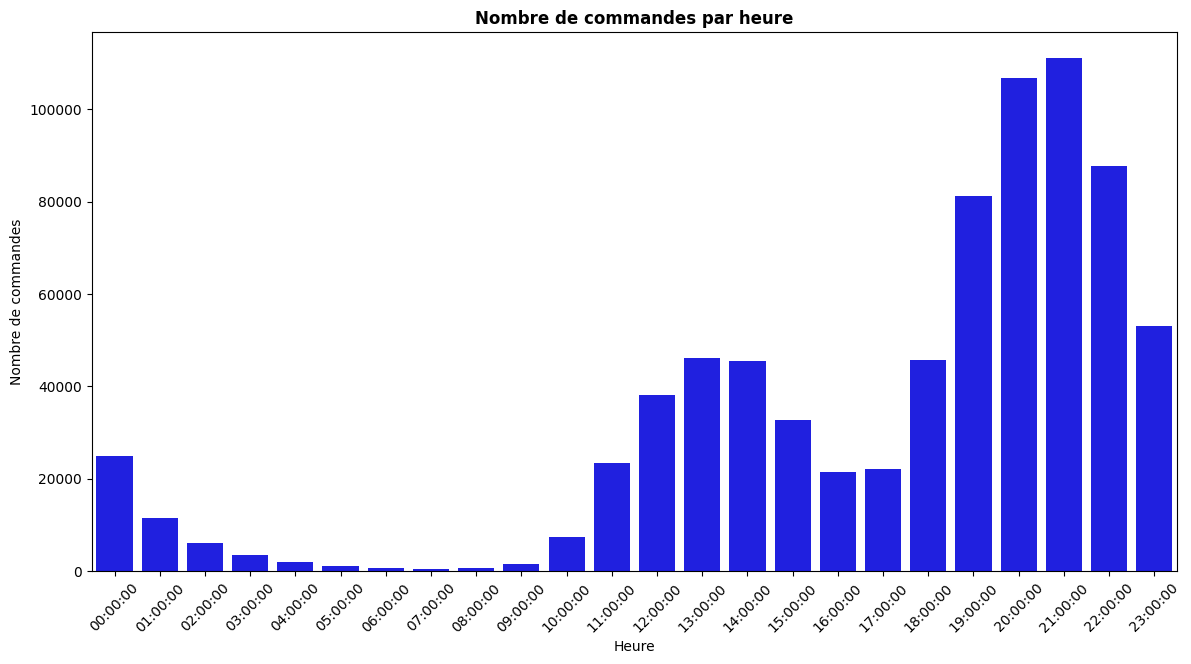

In [224]:
plt.figure(figsize=(14, 7))
sns.barplot(data=commandes_hours, x='hour', y='orders', color='blue')
plt.title('Nombre de commandes par heure', fontsize=12, fontweight='bold')
plt.ylabel('Nombre de commandes')
plt.xlabel('Heure')
plt.xticks(rotation=45)
plt.show()

### <a id="concurrent"></a>Analyse par concurrent

#### Deliveroo
> Exploration des données spécifiques à Deliveroo

In [225]:
# On definit des variables pour Deliveroo
df_deliveroo = df_transactions[(df_transactions['merchant_name']) == 'deliveroo']
deliveroo_gender = df_deliveroo['synthetic_gender'].value_counts()
deliveroo_generation = df_deliveroo['synthetic_age_generation'].value_counts()

In [226]:
# On calcule le montant moyen des frais de Deliveroo
mean_order_deliveroo = round(df_deliveroo['total_fees'].mean(),2)
print(f'Le montant moyen des frais sur Deliveroo est de {mean_order_deliveroo}€')

Le montant moyen des frais sur Deliveroo est de 2.26€


In [227]:
# Calcul du nombre de commande et de la proportion des promotions Deliveroo
promo_ratio_deliveroo = round(df_deliveroo['is_promo'].value_counts(normalize = True) * 100,2)
print(f'{promo_ratio_deliveroo.iloc[1]} % des commandes effectuées sur Deliveroo ont bénéficié de promotions')
print(f'{promo_ratio_deliveroo.iloc[0]} % des commandes effectuées sur Deliveroo n\'ont pas bénéficié de promotion')

13.45 % des commandes effectuées sur Deliveroo ont bénéficié de promotions
86.55 % des commandes effectuées sur Deliveroo n'ont pas bénéficié de promotion


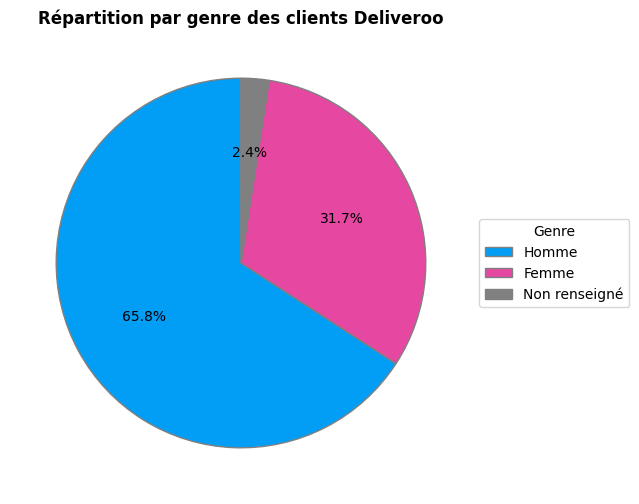

In [228]:
# Répartition par genre des clients Deliveroo
colors = palette_genre.values()
plt.figure(figsize=(6, 6))
plt.title('Répartition par genre des clients Deliveroo', fontsize=12, fontweight='bold')
plt.pie(
    deliveroo_gender.values,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'grey'},
    textprops={'fontsize': 10}
)
plt.legend(
    labels=['Homme', 'Femme', 'Non renseigné'],
    title="Genre",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.show()

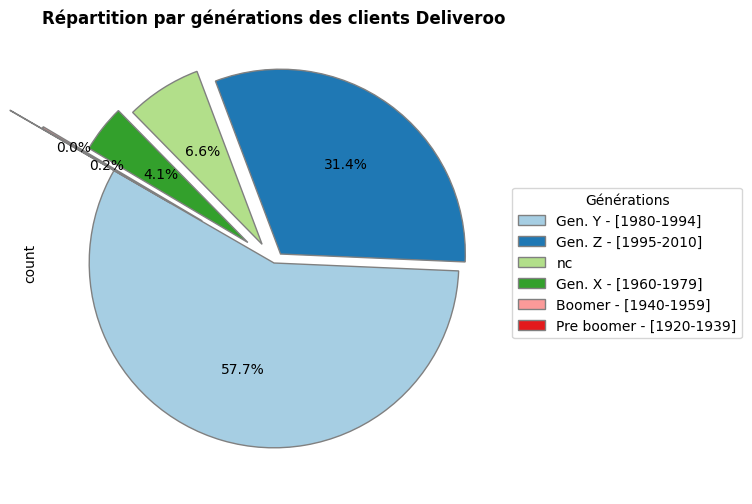

In [229]:
# Répartition par générations des clients Deliveroo
plt.figure(figsize=(6, 6))
plt.title('Répartition par générations des clients Deliveroo', fontsize=12, fontweight='bold')
deliveroo_generation.plot.pie(autopct='%1.1f%%',
                              startangle=150,
                              wedgeprops={'edgecolor': 'grey'},
                              labels=None,
                              colors=palette_geo,
                              explode=[0.0, 0.06, 0.12, 0.18, 0.45, 0.65])
plt.legend(deliveroo_generation.index, title="Générations", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

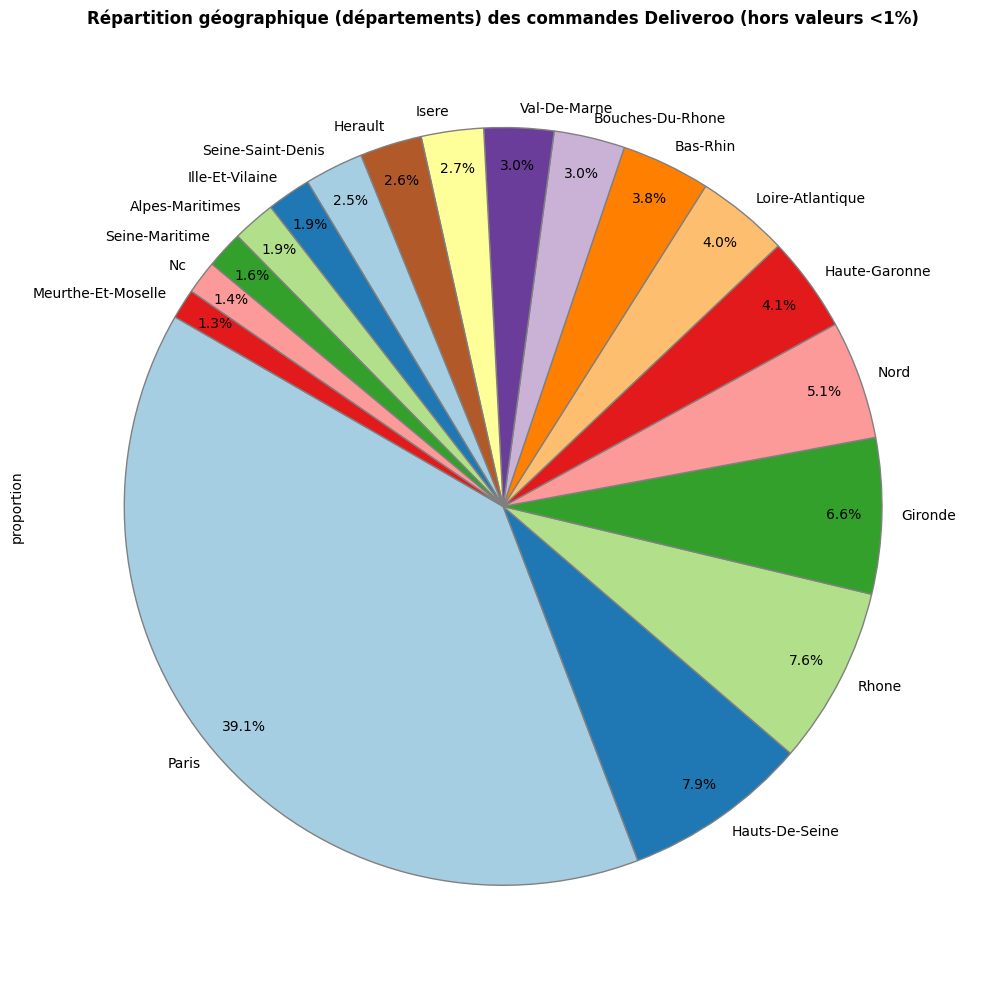

In [230]:
# Répartition géographique (par département) des commandes Deliveroo (hors valeurs <1%)

# Variables de répartition géographiques des commandes Deliveroo
deliveroo_geo = df_deliveroo['order_item_delivery_address_subregion'].value_counts(normalize = True)
deliveroo_region = df_deliveroo['order_item_delivery_address_region'].value_counts(normalize = True)

# On écarte les valeurs <1%
deliveroo_geo = deliveroo_geo[deliveroo_geo > 0.01]
deliveroo_region = deliveroo_region[deliveroo_region > 0.01]

plt.figure(figsize=(10, 10))
plt.title('Répartition géographique (départements) des commandes Deliveroo (hors valeurs <1%)', fontsize=12, fontweight='bold')
deliveroo_geo.plot.pie(autopct='%1.1f%%',
                       startangle=150,
                       wedgeprops={'edgecolor': 'grey'},
                       pctdistance=0.90,
                       labeldistance=1.05,
                       colors=palette_geo)
plt.tight_layout()
plt.show()

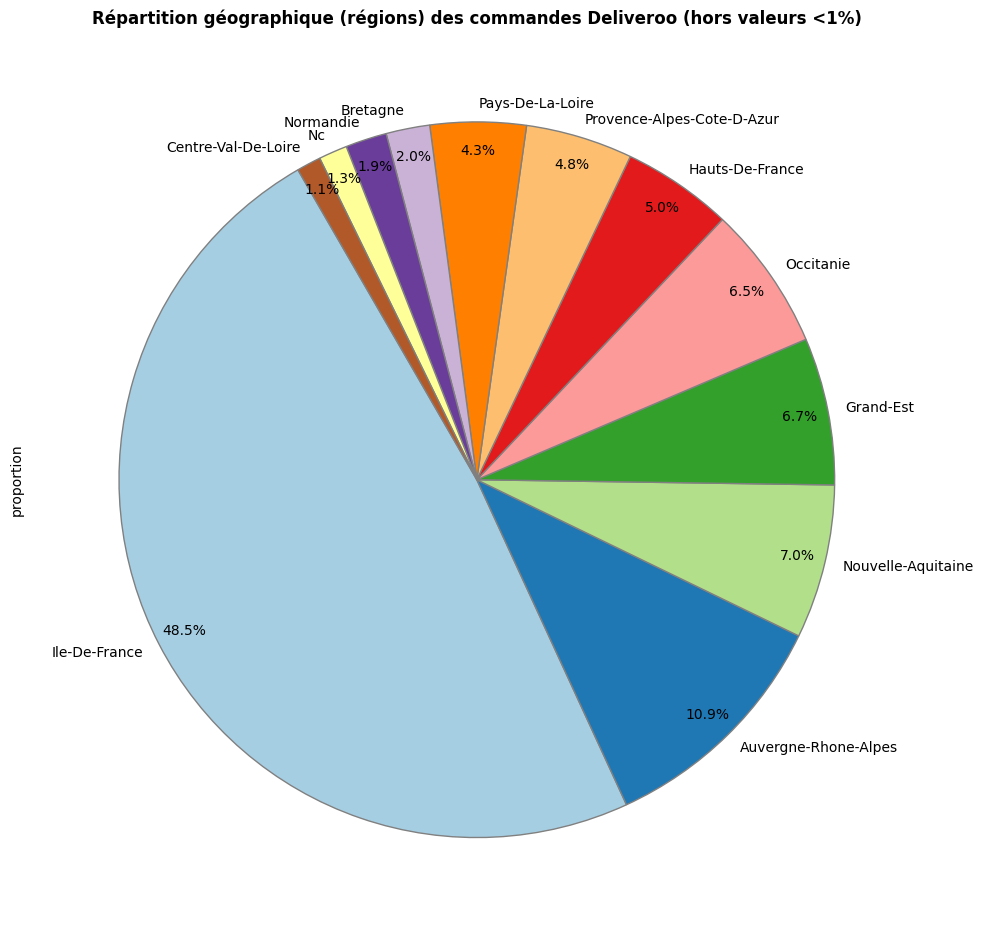

In [231]:
# Répartition géographique (régions) des commandes Deliveroo (hors valeurs <1%)
plt.figure(figsize=(10, 10))
plt.title('Répartition géographique (régions) des commandes Deliveroo (hors valeurs <1%)', fontsize=12, fontweight='bold')
deliveroo_region.plot.pie(autopct='%1.1f%%',
                          startangle=120,
                          wedgeprops={'edgecolor': 'grey'},
                          pctdistance=0.92,
                          labeldistance=1.05,
                          colors=palette_geo)
plt.tight_layout()
plt.show()

#### Uber Eats
> Exploration des données spécifiques à Uber Eat

In [232]:
# On definit des variables pour Uber Eats
df_uber = df_transactions[(df_transactions['merchant_name']) == 'uber eats']
uber_gender = df_uber['synthetic_gender'].value_counts()
uber_generation = df_uber['synthetic_age_generation'].value_counts()

In [233]:
# On calcule le montant moyen des frais de Uber Eats
mean_order_uber = round(df_uber['total_fees'].mean(),2)
print(f'Le montant moyen des frais sur Uber Eats est de {mean_order_uber}€')

Le montant moyen des frais sur Uber Eats est de 3.13€


In [234]:
# Calcul du nombre de commande et de la proportion des promotions Deliveroo
promo_ratio_uber = round(df_uber['is_promo'].value_counts(normalize = True) * 100,2)
print(f'{promo_ratio_uber[1]} % des commandes effectuées sur uber ont bénéficié de promotions')
print(f'{promo_ratio_uber[0]} % des commandes effectuées sur uber n\'ont pas bénéficié de promotion')

12.77 % des commandes effectuées sur uber ont bénéficié de promotions
87.23 % des commandes effectuées sur uber n'ont pas bénéficié de promotion


<ipython-input-234-b3c25ce3aa93>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-234-b3c25ce3aa93>:4: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



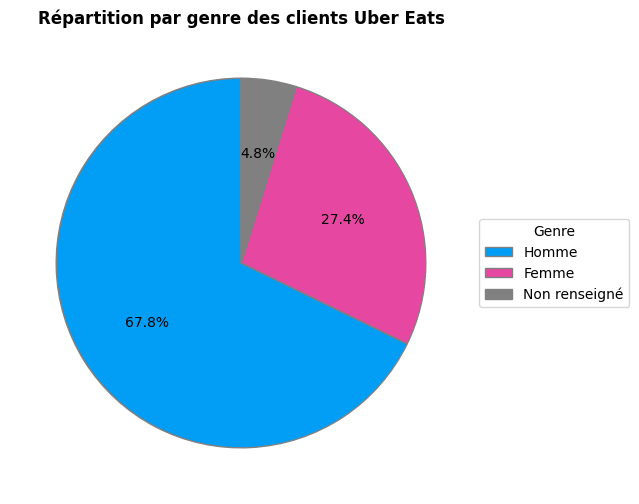

In [235]:
# Répartition par genre des clients Deliveroo
plt.figure(figsize=(6, 6))
colors = palette_genre.values()
plt.title('Répartition par genre des clients Uber Eats', fontsize=12, fontweight='bold')
plt.pie(
        uber_gender,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'grey'},
        textprops={'fontsize': 10}
)
plt.legend(
        labels=['Homme', 'Femme', 'Non renseigné'],
        title="Genre",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.show()

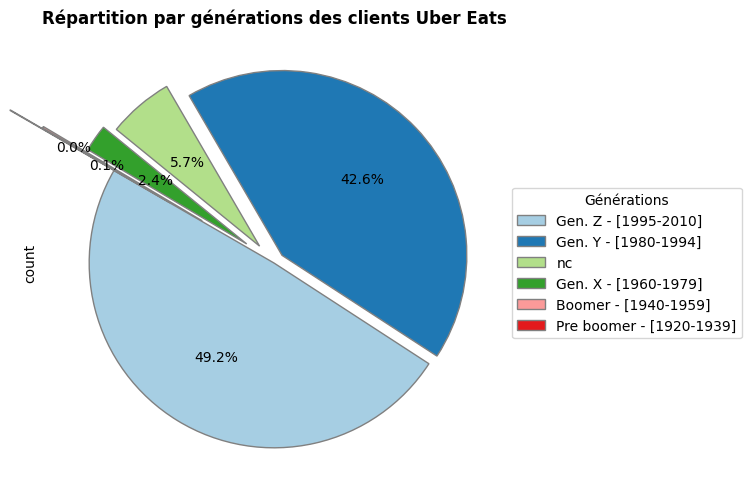

In [236]:
# Répartition par générations des clients Uber Eats
plt.figure(figsize=(6, 6))
plt.title('Répartition par générations des clients Uber Eats', fontsize=12, fontweight='bold')
uber_generation.plot.pie(autopct='%1.1f%%',
                         startangle=150,
                         wedgeprops={'edgecolor': 'grey'},
                         labels=None, colors=palette_geo,
                         explode=[0.0, 0.06, 0.12, 0.18, 0.45, 0.65])
plt.legend(uber_generation.index, title="Générations", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

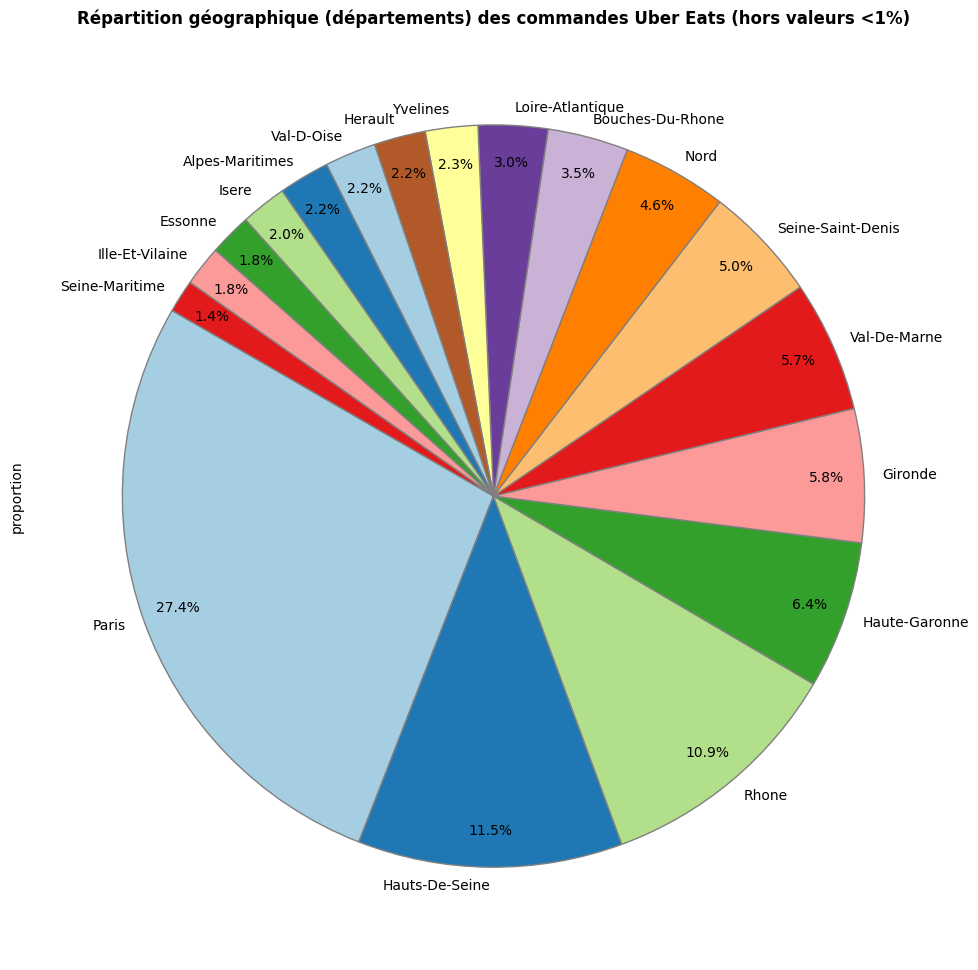

In [237]:
# Répartition géographique (par département) des commandes Uber Eats

# Variables de répartition géographiques des commandes uber
uber_geo = df_uber['order_item_delivery_address_subregion'].value_counts(normalize = True)
uber_region = df_uber['order_item_delivery_address_region'].value_counts(normalize = True)

# On écarte les valeurs <1%
uber_geo = uber_geo[uber_geo > 0.01]
uber_region = uber_region[uber_region > 0.01]

plt.figure(figsize=(10, 10))
plt.title('Répartition géographique (départements) des commandes Uber Eats (hors valeurs <1%)', fontsize=12, fontweight='bold')
uber_geo.plot.pie(autopct='%1.1f%%',
                  startangle=150,
                  wedgeprops={'edgecolor': 'grey'},
                  pctdistance=0.90,
                  labeldistance=1.05,
                  colors=palette_geo)
plt.tight_layout()
plt.show()

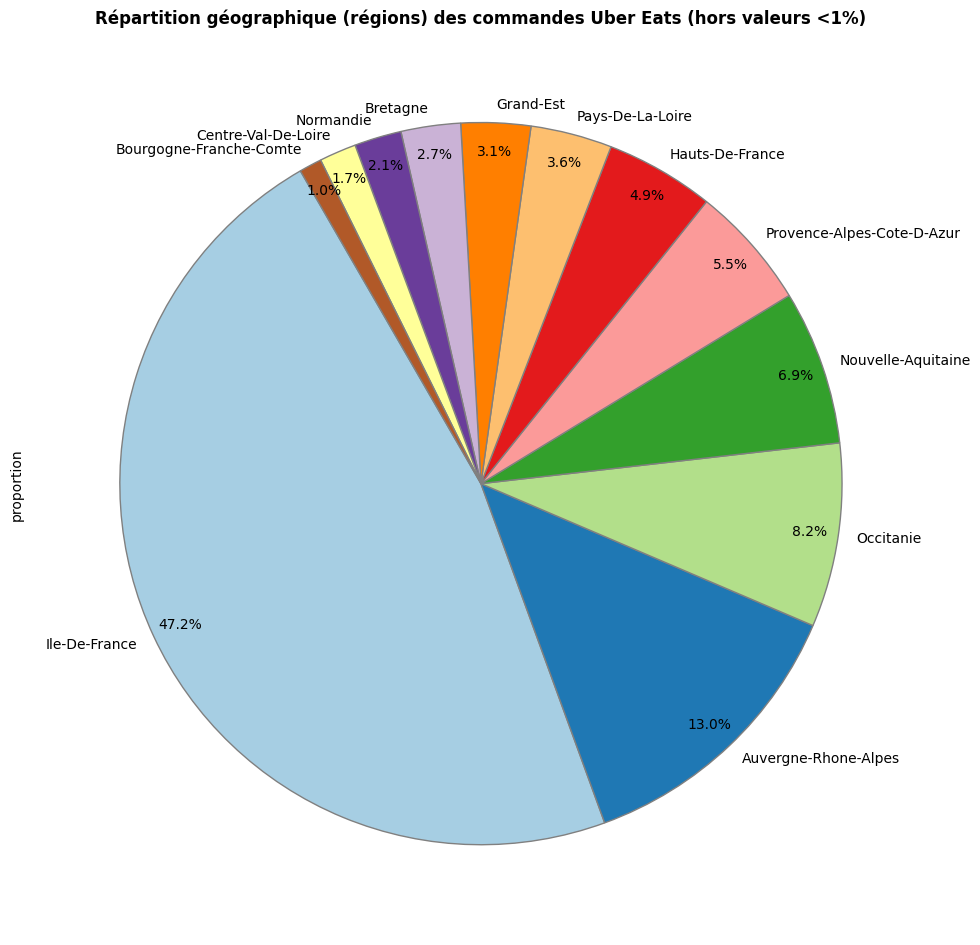

In [238]:
# Répartition géographique (par région) des commandes Uber Eats
plt.figure(figsize=(10, 10))
plt.title('Répartition géographique (régions) des commandes Uber Eats (hors valeurs <1%)', fontsize=12, fontweight='bold')
uber_region.plot.pie(autopct='%1.1f%%',
                     startangle=120,
                     wedgeprops={'edgecolor': 'grey'},
                     pctdistance=0.92,
                     labeldistance=1.05,
                     colors=palette_geo)
plt.tight_layout()
plt.show()

### <a id="market"></a>Parts de marché et chiffre d'affaire

In [239]:
# Parts de marchés en CA des concurrents :
market_share = round(df_transactions[df_transactions['merchant_name'] != 'just eat'].groupby('merchant_name')['order_total'].sum() / df_transactions['order_total'].sum() * 100, 2)
market_share.to_frame()

,order_total
merchant_name,
deliveroo,38.18
uber eats,61.71


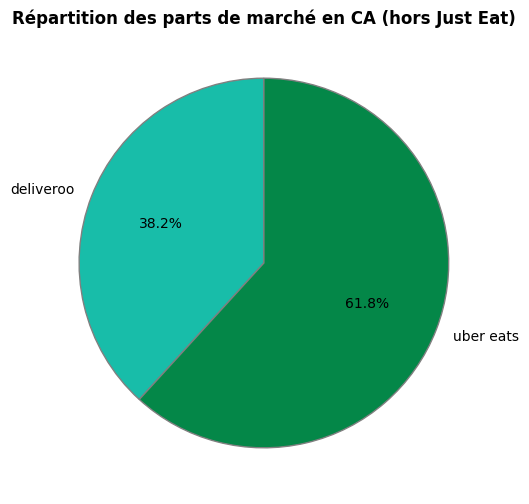

In [240]:
plt.figure(figsize=(6, 6))
colors = [palette[merchant] for merchant in market_share.index]
plt.pie(
    market_share.values,
    labels=market_share.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'grey'},
    textprops={'fontsize': 10}
)
plt.title('Répartition des parts de marché en CA (hors Just Eat)', fontsize=12, fontweight='bold')
plt.show()

<ipython-input-241-9a04a015c2c6>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



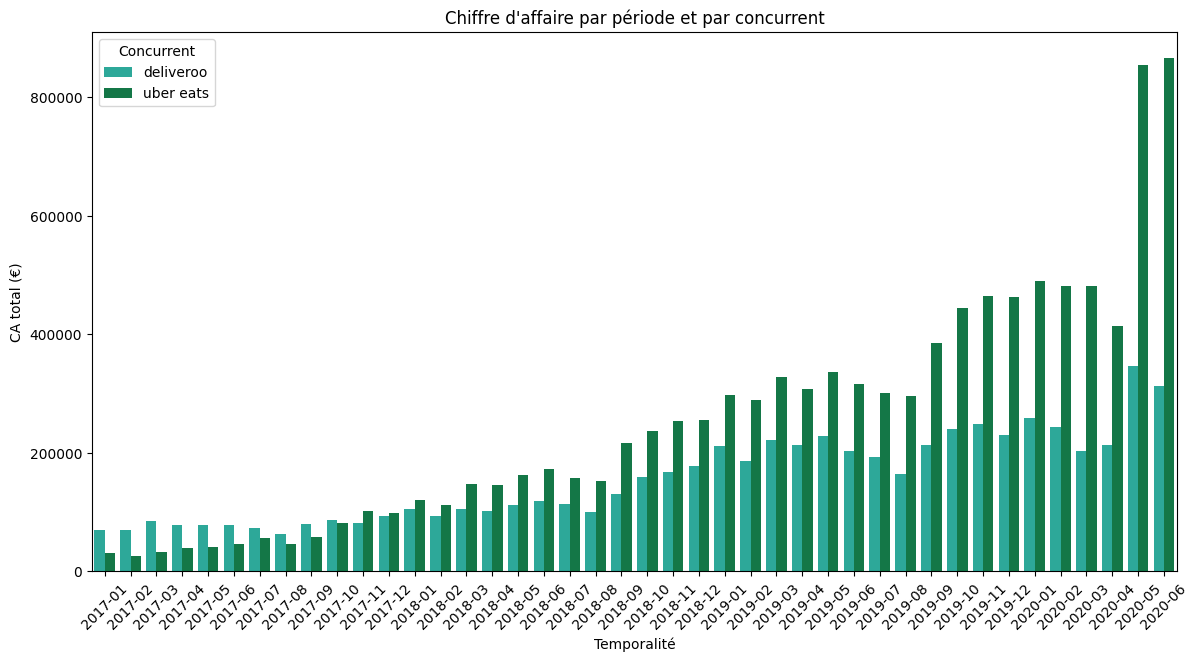

In [241]:
# Chiffre d'affaire par période et par concurrent
df_transactions_no_just_eat.loc[:, 'period'] = df_transactions['order_datetime'].dt.to_period("M")
ca_global = df_transactions_no_just_eat.groupby(['period', 'merchant_name'])['order_total'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(y=ca_global['order_total'], x=ca_global['period'], hue=ca_global['merchant_name'], palette=palette, errorbar=None)
plt.ylabel('CA total (€)')
plt.xlabel('Temporalité')
plt.title('Chiffre d\'affaire par période et par concurrent')
plt.xticks(rotation=45)
plt.legend(title='Concurrent')
plt.show()

In [242]:
# Chiffre d'affaire global par jour sous forme de calendrier
df_calendar = df_transactions_no_just_eat[['order_datetime', 'order_total']]
grouped_total = df_calendar.groupby(df_calendar['order_datetime'].dt.date)['order_total'].count().to_frame().reset_index()

fig = calplot(
         grouped_total,
         x="order_datetime",
         y="order_total",
         dark_theme=True,
         years_title=True
)
fig.show()

### <a id="panier-moyen"></a>Paniers moyens

In [243]:
# On calcul le panier moyen
average_basket = round(np.mean(df_transactions_no_just_eat['order_total']),2)
print(f'Le panier moyen global est de : {average_basket} €')

# On calcule le panier moyen d'une commande Uber Eats
average_basket_uber_eats = round(np.mean(df_uber['order_total']),2)
print(f'Le panier moyen d\'une commande Uber est de : {average_basket_uber_eats} €')

# On calcule le panier moyen d'une commande Deliveroo
average_basket_deliveroo = round(np.mean(df_deliveroo['order_total']),2)
print(f'Le panier moyen d\'une commande Deliveroo est de : {average_basket_deliveroo} €')


Le panier moyen global est de : 24.38 €
Le panier moyen d'une commande Uber est de : 23.94 €
Le panier moyen d'une commande Deliveroo est de : 25.13 €


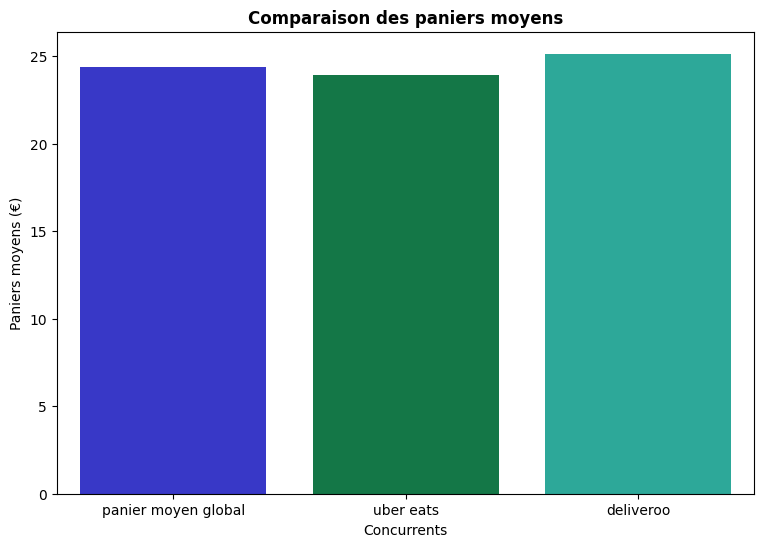

In [244]:
# On observe les informations sur les paniers moyens sur un graphique
average_basket_values = [average_basket, average_basket_uber_eats, average_basket_deliveroo]
labels = ['panier moyen global', 'uber eats', 'deliveroo']

plt.figure(figsize=(9, 6))
sns.barplot(x=labels, y=average_basket_values, hue=labels, palette=palette)
plt.xlabel('Concurrents')
plt.ylabel('Paniers moyens (€)')
plt.title('Comparaison des paniers moyens', fontsize=12, fontweight='bold')
plt.show()

### <a id="clients"></a>Analyse de la clientèle

In [245]:
# On regarde le nombre de commandes par client, pour identifier les typologies de clients les plus représentés
client = df_transactions.groupby(['synthetic_gender', 'synthetic_age_generation'])['order_total'].sum().reset_index().sort_values(by='order_total', ascending=False)
client

,synthetic_gender,synthetic_age_generation,order_total
8,male,Gen. Y - [1980-1994],5876408.4
9,male,Gen. Z - [1995-2010],4409201.6
2,female,Gen. Y - [1980-1994],2648461.6
3,female,Gen. Z - [1995-2010],1894204.7
11,male,nc,667974.5
7,male,Gen. X - [1960-1979],422235.1
15,nc,Gen. Z - [1995-2010],420764.4
5,female,nc,376100.2
1,female,Gen. X - [1960-1979],210694.7
14,nc,Gen. Y - [1980-1994],169924.8


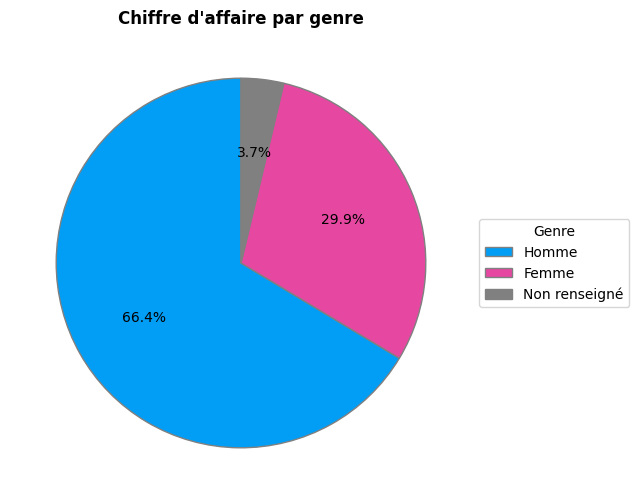

In [246]:
# On visualise la répartition par genre dans l'apport de CA
gender_ca = df_transactions_no_just_eat.groupby('synthetic_gender')['order_total'].sum().sort_values(ascending=False)

plt.figure(figsize=(6, 6))
colors = palette_genre.values()
plt.title('Chiffre d\'affaire par genre', fontsize=12, fontweight='bold')
plt.pie(gender_ca,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'grey'},
        textprops={'fontsize': 10}
)
plt.legend(labels=['Homme', 'Femme', 'Non renseigné'],
           title="Genre",
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1),
)
plt.show()

> Les hommes représentent 2/3 du chiffre d'affaires des concurrents.

### <a id="corr"></a>Observations des corrélations

In [247]:
# On definit des variables pour les les analyses de corrélations (en excluant Just Eat)

# 'synthetic_gender'
gender_code = pd.Categorical(df_transactions_no_just_eat['synthetic_gender'], categories=['nc', 'male', 'female']).codes

# 'synthetic_age_generation'
generation_code = pd.Categorical(df_transactions_no_just_eat['synthetic_age_generation']).codes

# 'pourcentage_promo'
promotion_percent = df_transactions_no_just_eat['pourcentage_promo'].fillna(0)
promotion_bool = df_transactions_no_just_eat['is_promo']
promotion_total = df_transactions_no_just_eat['order_total_promo']

# 'order total'
fees = df_transactions_no_just_eat['total_fees']

# 'order total'
ca = df_transactions_no_just_eat['order_total']

# 'region'
region_code = pd.Categorical(df_transactions_no_just_eat['order_item_delivery_address_region']).codes


In [248]:
# On creer un dataframe pour analyser les corrélations
df_correlation = pd.DataFrame({
    'genre': gender_code,
    'generation': generation_code,
    'region' : region_code,
    '% promotion': promotion_percent,
    'is promo' : promotion_bool,
    'montant promo' : promotion_total,
    'frais' : fees,
    'chiffre d\'affaire' : ca
})

df_correlation.corr()

,genre,generation,region,% promotion,is promo,montant promo,frais,chiffre d'affaire
genre,1.000000,-0.012528,0.016571,0.000954,0.005046,0.005621,-0.015218,0.040034
generation,-0.012528,1.000000,-0.025287,0.035812,0.028549,0.025248,0.037769,-0.084960
region,0.016571,-0.025287,1.000000,-0.012707,-0.016383,-0.007971,0.001376,0.016410
% promotion,0.000954,0.035812,-0.012707,1.000000,0.792241,0.901111,0.011730,-0.000522
is promo,0.005046,0.028549,-0.016383,0.792241,1.000000,0.791897,0.059635,0.078855
montant promo,0.005621,0.025248,-0.007971,0.901111,0.791897,1.000000,0.054780,0.120083
frais,-0.015218,0.037769,0.001376,0.011730,0.059635,0.054780,1.000000,0.190538
chiffre d'affaire,0.040034,-0.084960,0.016410,-0.000522,0.078855,0.120083,0.190538,1.000000


<Axes: >

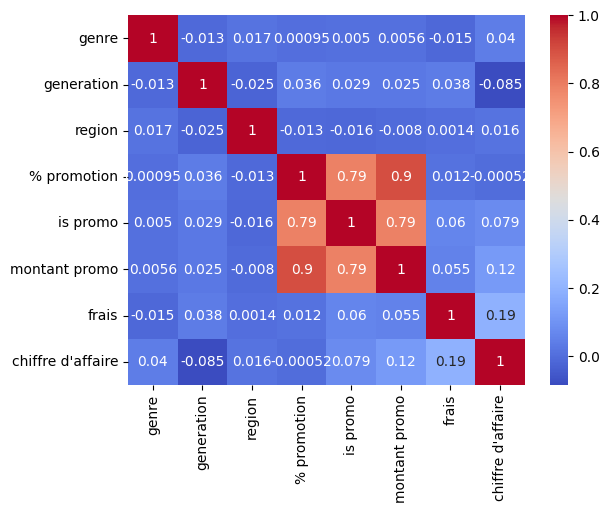

In [249]:
sns.heatmap(df_correlation.corr(), annot=True, cmap='coolwarm')

> **Nous ne constatons pas de corrélation entre ces différentes variables.** Sur le CA nous constatons un impact potentiel des frais de livraison mais mériterait une étude complémentaire avec plus de données.

### <a id="geo"></a>Analyses géographiques

In [250]:
# Répartition du CA par région
ca_by_region = df_transactions.groupby('order_item_delivery_address_region')['order_total'].sum().sort_values(ascending=False).reset_index()
ca_by_region

,order_item_delivery_address_region,order_total
0,Ile-De-France,8352342.6
1,Auvergne-Rhone-Alpes,2036331.1
2,Occitanie,1257659.6
3,Nouvelle-Aquitaine,1142367.4
4,Provence-Alpes-Cote-D-Azur,935293.8
5,Hauts-De-France,817535.1
6,Grand-Est,728867.7
7,Pays-De-La-Loire,662643.4
8,Bretagne,395761.5
9,Normandie,340512.3


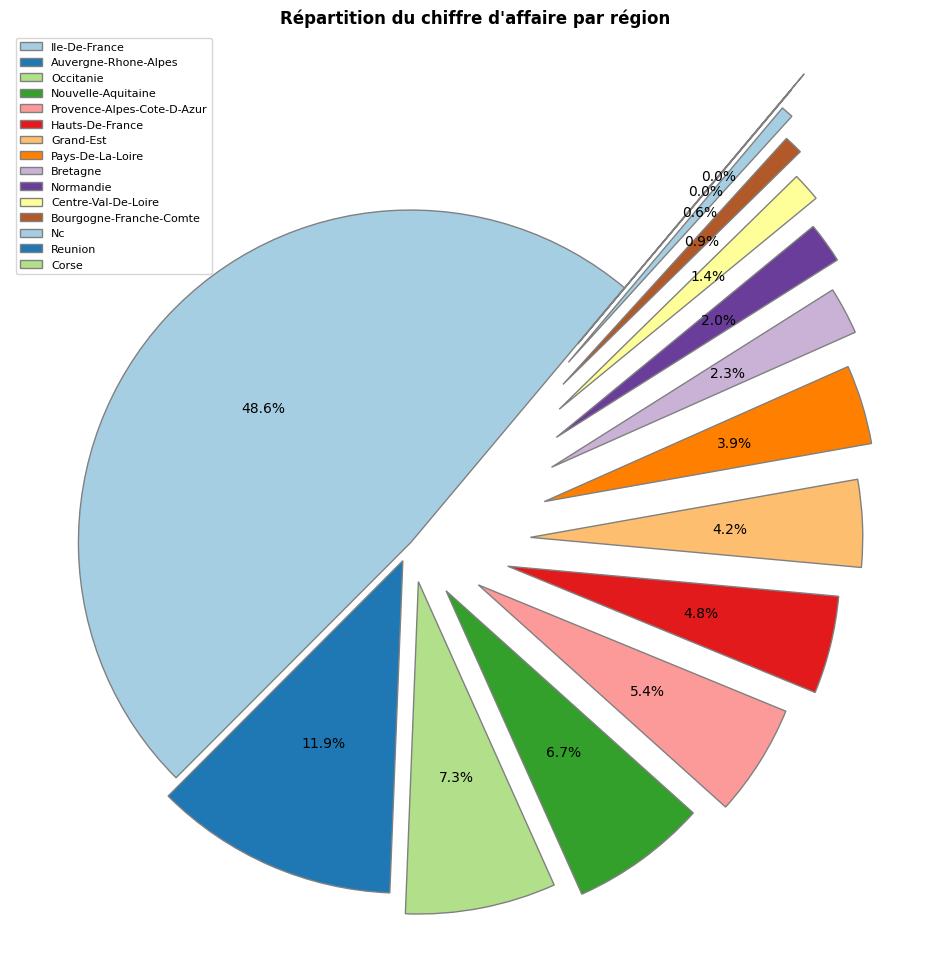

In [251]:
plt.figure(figsize=(12,12))
colors = palette_geo
explode = [i * 0.06 for i in range(len(ca_by_region))]
plt.title("Répartition du chiffre d'affaire par région", fontsize=12, fontweight='bold')

plt.pie(ca_by_region['order_total'],
        autopct='%1.1f%%',
        startangle=50,
        explode=explode,
        colors=colors,
        wedgeprops={'edgecolor': 'grey'},
        textprops={'fontsize': 10})
plt.legend(labels=ca_by_region['order_item_delivery_address_region'], loc="upper left", fontsize=8)
plt.axis('equal')
plt.show()

> L'Île-de-France représente près de la moitié du marché.

In [252]:
# Répartition du CA par région
ca_by_dpt = df_transactions.groupby('order_item_delivery_address_subregion')['order_total'].sum().sort_values(ascending=False).reset_index()
ca_by_dpt = ca_by_dpt.head(16)
ca_by_dpt

,order_item_delivery_address_subregion,order_total
0,Paris,4684519.5
1,Hauts-De-Seine,1550189.4
2,Rhone,1373875.3
3,Gironde,865168.2
4,Haute-Garonne,783775.6
5,Val-De-Marne,685924.4
6,Nord,679938.7
7,Seine-Saint-Denis,610683.9
8,Bouches-Du-Rhone,500996.5
9,Loire-Atlantique,493517.3


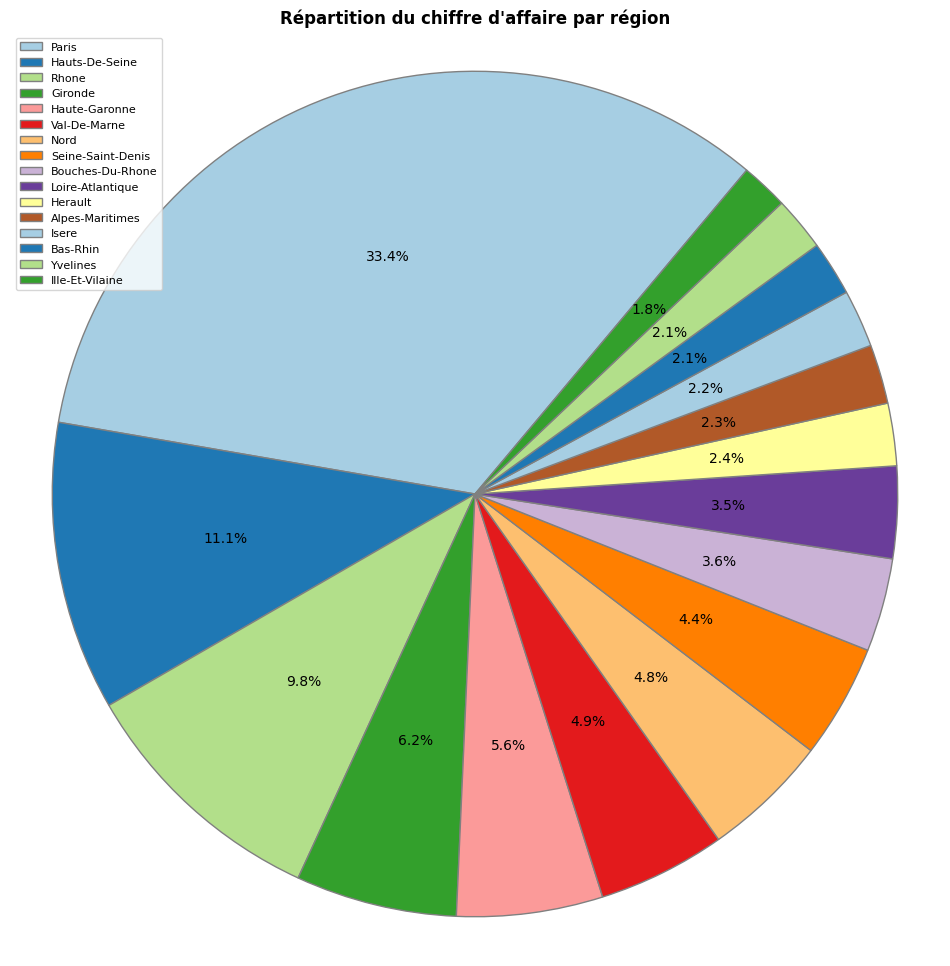

In [253]:
plt.figure(figsize=(12,12))
colors = palette_geo
plt.title("Répartition du chiffre d'affaire par région", fontsize=12, fontweight='bold')

plt.pie(ca_by_dpt['order_total'],
        autopct='%1.1f%%',
        startangle=50,
        colors=colors,
        wedgeprops={'edgecolor': 'grey'},
        textprops={'fontsize': 10})
plt.legend(labels=ca_by_dpt['order_item_delivery_address_subregion'], loc="upper left",fontsize= 8)
plt.axis('equal')
plt.show()

In [254]:
# Répartion du chiffre d\'affaire par département et par concurrent
ca_by_dpt = df_transactions_no_just_eat.groupby(['order_item_delivery_address_region','merchant_name'])['order_total'].sum().sort_values(ascending=False).reset_index()
display(ca_by_dpt)

,order_item_delivery_address_region,merchant_name,order_total
0,Ile-De-France,uber eats,5045153.5
1,Ile-De-France,deliveroo,3296682.4
2,Auvergne-Rhone-Alpes,uber eats,1360919.9
3,Occitanie,uber eats,865948.2
4,Nouvelle-Aquitaine,uber eats,708938.8
5,Auvergne-Rhone-Alpes,deliveroo,674068.0
6,Provence-Alpes-Cote-D-Azur,uber eats,622871.1
7,Hauts-De-France,uber eats,502209.2
8,Nouvelle-Aquitaine,deliveroo,432967.3
9,Grand-Est,deliveroo,401167.7


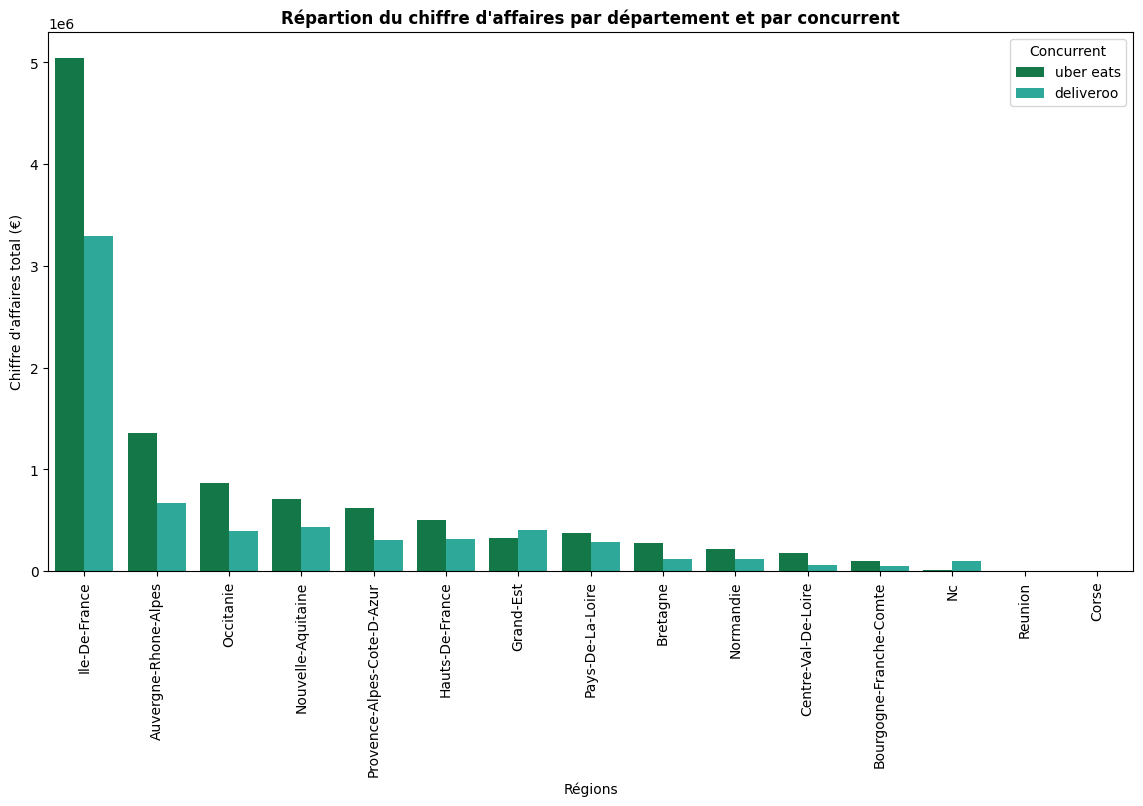

In [255]:
plt.figure(figsize=(14, 7))
sns.barplot(data=ca_by_dpt, x='order_item_delivery_address_region', y='order_total', hue='merchant_name', palette=palette)
plt.xlabel('Régions')
plt.ylabel('Chiffre d\'affaires total (€)')
plt.title('Répartion du chiffre d\'affaires par département et par concurrent', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)
plt.legend(title='Concurrent')
plt.show()

In [256]:
# Observation du maillage du territoire par les différents concurrents
count_dpt = df_transactions.groupby(['merchant_name', 'order_item_delivery_address_subregion'])['order_item_delivery_address_subregion'].count().unstack(level=0).fillna(0)
count_dpt_deliveroo = count_dpt['deliveroo'][count_dpt['uber eats'] > 0].count()
count_dpt_uber = count_dpt['uber eats'][count_dpt['deliveroo'] > 0].count()
count_dpt_just_eat = count_dpt['just eat'][count_dpt['just eat'] > 0].count()
print('Nombre de départements dans lesquels chaque concurrent est présent :')
print(f'Deliveroo : {count_dpt_deliveroo}')
print(f'Uber Eats : {count_dpt_uber}')
print(f'Just Eat : {count_dpt_just_eat}')

Nombre de départements dans lesquels chaque concurrent est présent :
Deliveroo : 94
Uber Eats : 63
Just Eat : 82


#### Cartographie

> Nous chargeons les données géographiques sur Datawrapper pour avoir une vision cartographique d'ensemble

In [257]:
# Slicing des données géographiques de Just Eat
transactions_just_eat = df_transactions[(df_transactions['order_datetime'] >= '2017-01-01') & (df_transactions['order_datetime'] <= '2019-07-31') & (df_transactions['merchant_name'] == 'just eat')]
just_eat_dpt = transactions_just_eat['order_item_delivery_address_subregion'].value_counts()
just_eat_dpt = transactions_just_eat.groupby(['order_item_delivery_address_subregion', 'departement_number']).size()

In [258]:
from IPython.display import IFrame
IFrame(src='https://datawrapper.dwcdn.net/M22dO/2/', width=800, height=720)

In [259]:
# Slicing des données géographiques de Uber Eats
transactions_uber = df_transactions[df_transactions['merchant_name'] == 'uber eats']
uber_dpt = transactions_uber['order_item_delivery_address_subregion'].value_counts()
uber_dpt = transactions_uber.groupby(['order_item_delivery_address_subregion', 'departement_number']).size()

In [260]:
IFrame(src='https://datawrapper.dwcdn.net/LdpOZ/2/', width=800, height=720)

In [261]:
### # Slicing des données géographiques de Deliveroo
transactions_deliveroo = df_transactions[df_transactions['merchant_name'] == 'deliveroo']
deliveroo_dpt = transactions_deliveroo['order_item_delivery_address_subregion'].value_counts()
deliveroo_dpt = transactions_deliveroo.groupby(['order_item_delivery_address_subregion', 'departement_number']).size()

In [262]:
IFrame(src='https://datawrapper.dwcdn.net/Oemlu/2/', width=800, height=720)

### <a id="idf"></a>Analyse IdF vs reste de la France

In [263]:
df_transactions_no_just_eat['order_item_delivery_address_region']

,order_item_delivery_address_region
0,Ile-De-France
1,Auvergne-Rhone-Alpes
2,Grand-Est
4,Ile-De-France
5,Ile-De-France
...,...
807670,Provence-Alpes-Cote-D-Azur
807672,Centre-Val-De-Loire
807673,Occitanie
807674,Hauts-De-France


<ipython-input-264-9d7e2eaf8ed7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-264-9d7e2eaf8ed7>:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Ile-De-France' 'Autres régions' 'Autres régions' ... 'Autres régions'
 'Autres régions' 'Ile-De-France']' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.



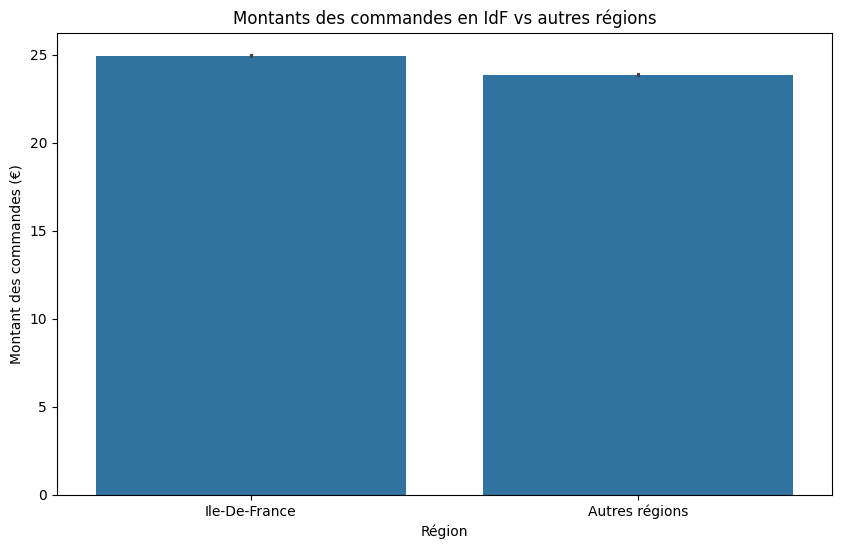

In [264]:
# Repartition des commandes entre IDF et les autres régions
df_transactions_no_just_eat.loc[:, 'is_idf'] = df_transactions_no_just_eat['order_item_delivery_address_region'] == 'Ile-De-France'
df_transactions_no_just_eat.loc[:, 'is_idf'] = df_transactions_no_just_eat['is_idf'].apply(lambda x: 'Ile-De-France' if x else 'Autres régions')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_transactions_no_just_eat, x='is_idf', y='order_total')
plt.title('Montants des commandes en IdF vs autres régions')
plt.ylabel('Montant des commandes (€)')
plt.xlabel('Région')
plt.show()

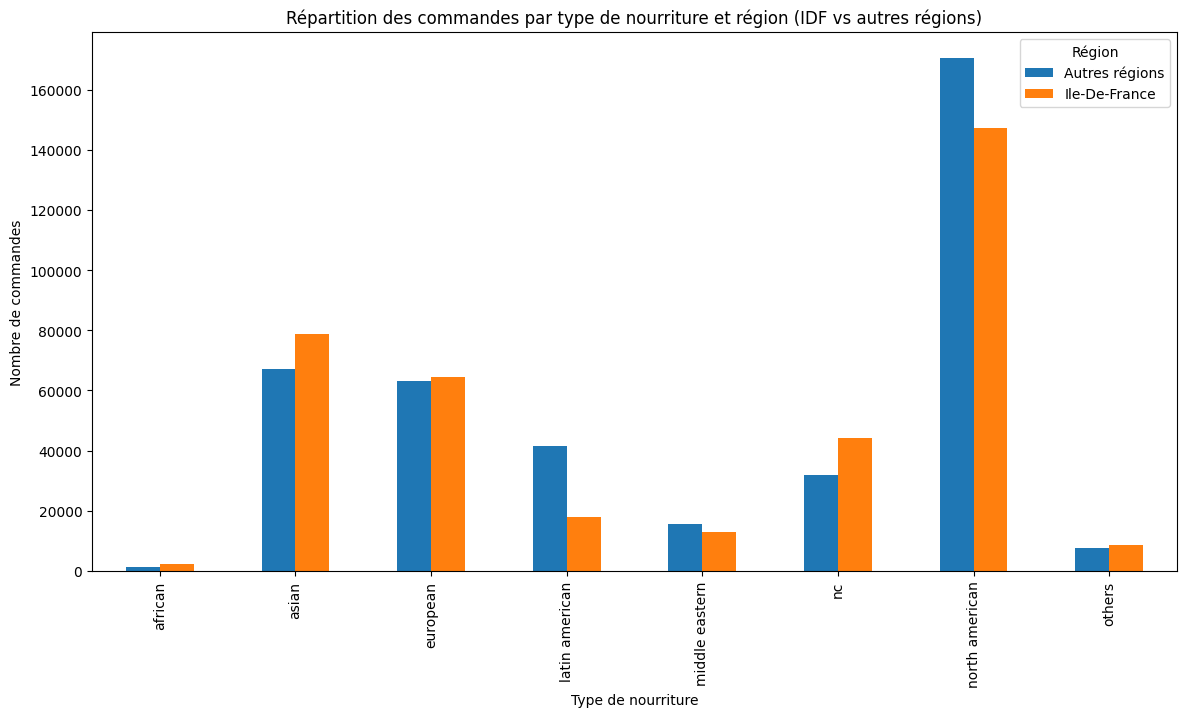

In [265]:
# Répartition des commandes par type de nourriture et région (IDF vs autres régions)
df_transactions['is_idf'] = df_transactions['order_item_delivery_address_region'] == 'Ile-De-France'
df_transactions['is_idf'] = df_transactions['is_idf'].apply(lambda x: 'Ile-De-France' if x else 'Autres régions')

continent_food_is_idf = df_transactions.groupby('continent_food')['is_idf'].value_counts()
continent_food_is_idf.unstack().plot(kind='bar', figsize=(14, 7))
plt.title('Répartition des commandes par type de nourriture et région (IDF vs autres régions)')
plt.xlabel('Type de nourriture')
plt.ylabel('Nombre de commandes')
plt.legend(title='Région')
plt.show()

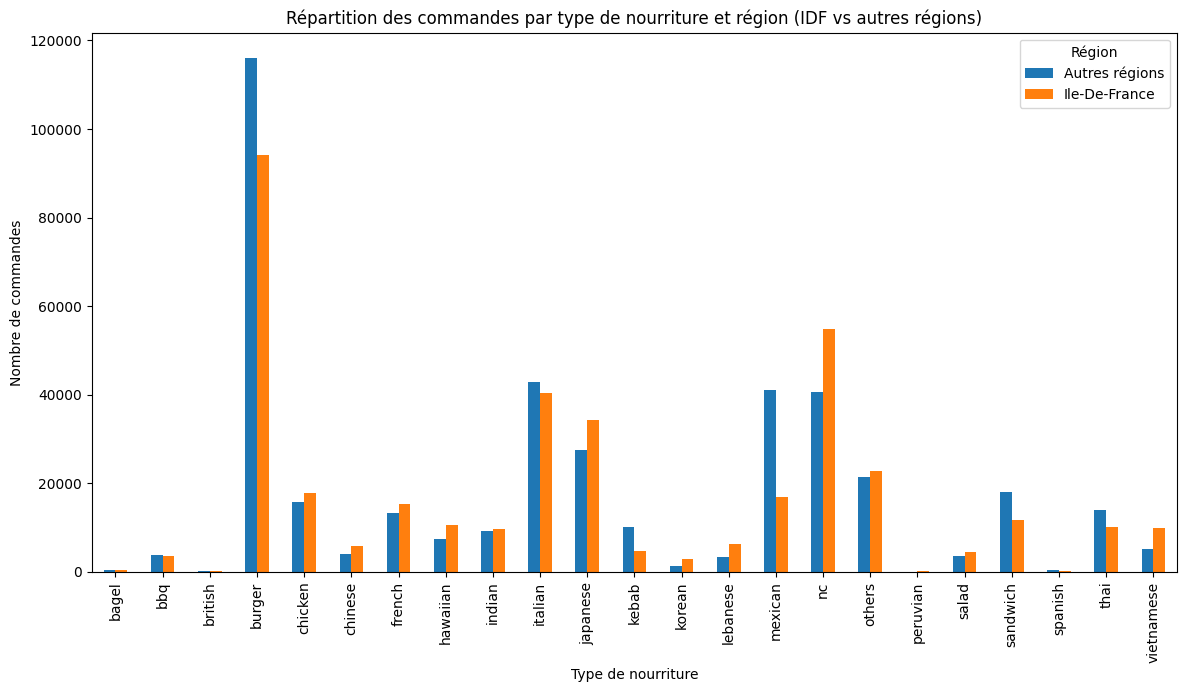

In [266]:
continent_food_is_idf_detail = df_transactions.groupby('type_food')['is_idf'].value_counts()
continent_food_is_idf_detail.unstack().plot(kind='bar', figsize=(14, 7))
plt.title('Répartition des commandes par type de nourriture et région (IDF vs autres régions)')
plt.xlabel('Type de nourriture')
plt.ylabel('Nombre de commandes')
plt.legend(title='Région')
plt.show()

### <a id="food"></a>Analyse des types de nourriture

In [267]:
type_food = df_transactions[df_transactions['type_food'] != 'nc'].groupby([df_transactions['order_datetime'].dt.to_period('M'), ('type_food')])['type_food'].count()

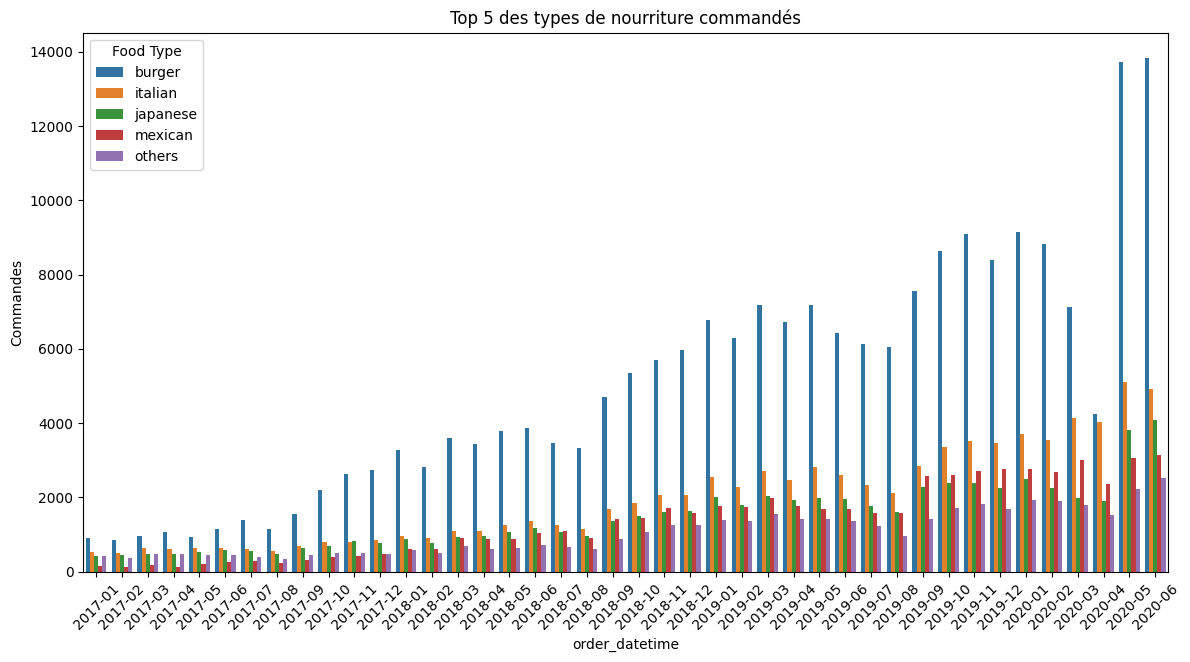

In [268]:
top_5_type_food = type_food.groupby('type_food').sum().nlargest(5)
top_5_type_food = type_food[type_food.index.get_level_values('type_food').isin(top_5_type_food.index)]

plt.figure(figsize=(14, 7))
sns.barplot(x=top_5_type_food.index.get_level_values('order_datetime'), y=top_5_type_food.values, hue=top_5_type_food.index.get_level_values('type_food'))
plt.ylabel('Commandes')
plt.title('Top 5 des types de nourriture commandés')
plt.xticks(rotation=45)
plt.legend(title='Food Type')
plt.show()

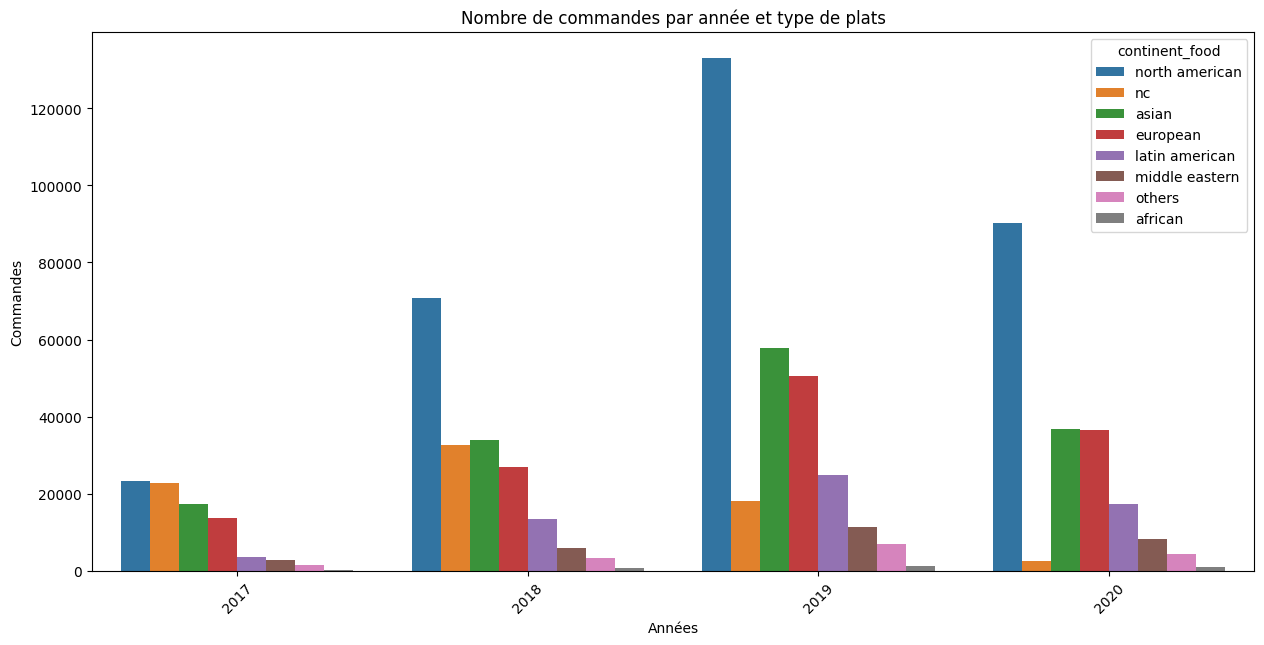

In [269]:
# Nombre de commandes par année et type de plats
df_transactions['year'] = df_transactions['order_datetime'].dt.year

type_food_period = df_transactions.groupby('year')["continent_food"].value_counts().to_frame().reset_index()
# Visualisation du nombre de commandes par année et type de nourriture
plt.figure(figsize=(15, 7))
sns.barplot(y=type_food_period['count'], x=type_food_period['year'], hue=type_food_period['continent_food'], errorbar=None)
plt.ylabel('Commandes')
plt.xlabel('Années')
plt.title('Nombre de commandes par année et type de plats')
plt.xticks(rotation=45)
plt.show()

### <a id="sellers"></a>Analyse des vendeurs

In [270]:
sellers = df_transactions['seller_name'].value_counts().head(40)

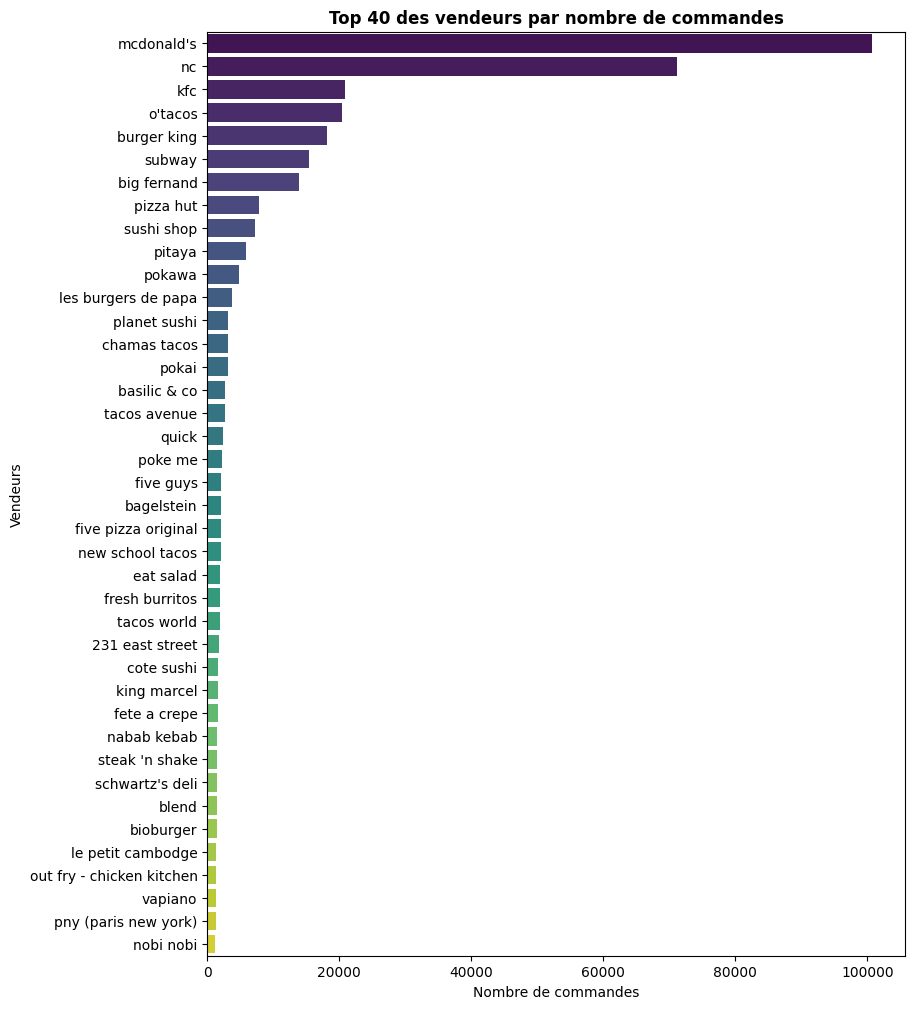

In [271]:
# Top 40 des vendeurs par nombre de commandes
plt.figure(figsize=(9, 12))
sns.barplot(x=sellers.values, y=sellers.index, hue=sellers.index, palette='viridis')
plt.xlabel('Nombre de commandes')
plt.ylabel('Vendeurs')
plt.title('Top 40 des vendeurs par nombre de commandes', fontsize=12, fontweight='bold')
plt.show()

### <a id="promo"></a>Analyse des promotions

In [272]:
# Analyse des promotions par jour et par concurrent :
promo = df_transactions_no_just_eat.groupby([df_transactions_no_just_eat['order_datetime'].dt.day_name(), 'merchant_name'])[['order_total']].count().reset_index().rename(columns={'order_datetime': 'day_of_week'})
promo['promo'] = df_transactions_no_just_eat[df_transactions_no_just_eat['is_promo']].groupby([df_transactions_no_just_eat['order_datetime'].dt.day_name(), 'merchant_name'])[['order_total']].count().reset_index(drop=True)
promo['no_promo'] = df_transactions_no_just_eat[~df_transactions_no_just_eat['is_promo']].groupby([df_transactions_no_just_eat['order_datetime'].dt.day_name(), 'merchant_name'])[['order_total']].count().reset_index(drop=True)

# On réordonne les jours de la semaine et on les renomme en français
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
promo['day_of_week'] = pd.Categorical(promo['day_of_week'], categories=days_order, ordered=True)
promo = promo.sort_values('day_of_week')
promo['day_of_week'] = promo['day_of_week'].cat.rename_categories({
    'Monday': 'Lundi',
    'Tuesday': 'Mardi',
    'Wednesday': 'Mercredi',
    'Thursday': 'Jeudi',
    'Friday': 'Vendredi',
    'Saturday': 'Samedi',
    'Sunday': 'Dimanche'
})

display(promo)

,day_of_week,merchant_name,order_total,promo,no_promo
2,Lundi,deliveroo,32924,4401,28523
3,Lundi,uber eats,53434,6234,47200
10,Mardi,deliveroo,33203,4197,29006
11,Mardi,uber eats,55829,6954,48875
12,Mercredi,deliveroo,35473,4786,30687
13,Mercredi,uber eats,58626,7490,51136
8,Jeudi,deliveroo,36914,4951,31963
9,Jeudi,uber eats,60811,7726,53085
0,Vendredi,deliveroo,40445,5376,35069
1,Vendredi,uber eats,68057,9566,58491


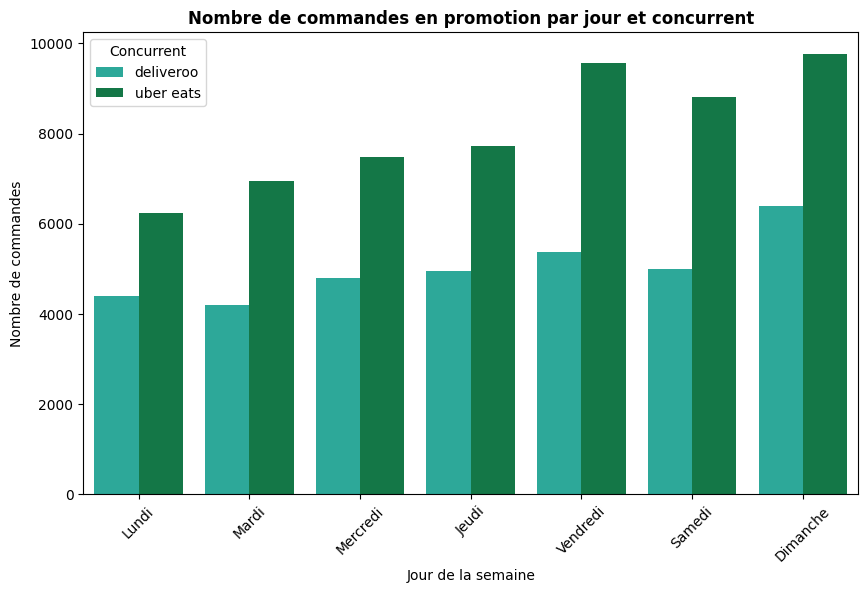

In [273]:
plt.figure(figsize=(10, 6))
sns.barplot(data=promo, x='day_of_week', y='promo', hue='merchant_name', palette=palette, errorbar=None)
plt.title('Nombre de commandes en promotion par jour et concurrent', fontsize=12, fontweight='bold')
plt.xlabel('Jour de la semaine')
plt.ylabel('Nombre de commandes')
plt.xticks(rotation=45)
plt.legend(title='Concurrent')
plt.show()

In [274]:
# Analyse des promotions par mois et par concurrent :
promo_month_comp = df_transactions_no_just_eat.groupby([df_transactions_no_just_eat['order_datetime'].dt.month_name(), 'merchant_name'])[['order_total']].count().reset_index().rename(columns={'order_datetime': 'month'})
promo_month_comp['promo'] = df_transactions_no_just_eat[df_transactions_no_just_eat['is_promo']].groupby([df_transactions_no_just_eat['order_datetime'].dt.month_name(), 'merchant_name'])[['order_total']].count().reset_index(drop=True)
promo_month_comp['no_promo'] = df_transactions_no_just_eat[~df_transactions_no_just_eat['is_promo']].groupby([df_transactions_no_just_eat['order_datetime'].dt.month_name(), 'merchant_name'])[['order_total']].count().reset_index(drop=True)

months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
promo_month_comp['month'] = pd.Categorical(promo_month_comp['month'], categories=months_order, ordered=True)
promo_month_comp = promo_month_comp.sort_values('month')
promo_month_comp['month'] = promo_month_comp['month'].cat.rename_categories({
    'January': 'Janvier',
    'February': 'Février',
    'March': 'Mars',
    'April': 'Avril',
    'May': 'Mai',
    'June': 'Juin',
    'July': 'Juillet',
    'August': 'Aout',
    'September': 'Septembre',
    'October': 'Octobre',
    'November': 'Novembre',
    'December': 'Décembre'
})
display(promo_month_comp)

,month,merchant_name,order_total,promo,no_promo
8,Janvier,deliveroo,26224,3706,22518
9,Janvier,uber eats,40186,3962,36224
6,Février,deliveroo,23621,3224,20397
7,Février,uber eats,39065,3721,35344
15,Mars,uber eats,42623,6880,35743
14,Mars,deliveroo,24383,3247,21136
0,Avril,deliveroo,23282,3391,19891
1,Avril,uber eats,36298,3637,32661
17,Mai,uber eats,52684,8397,44287
16,Mai,deliveroo,29192,4088,25104


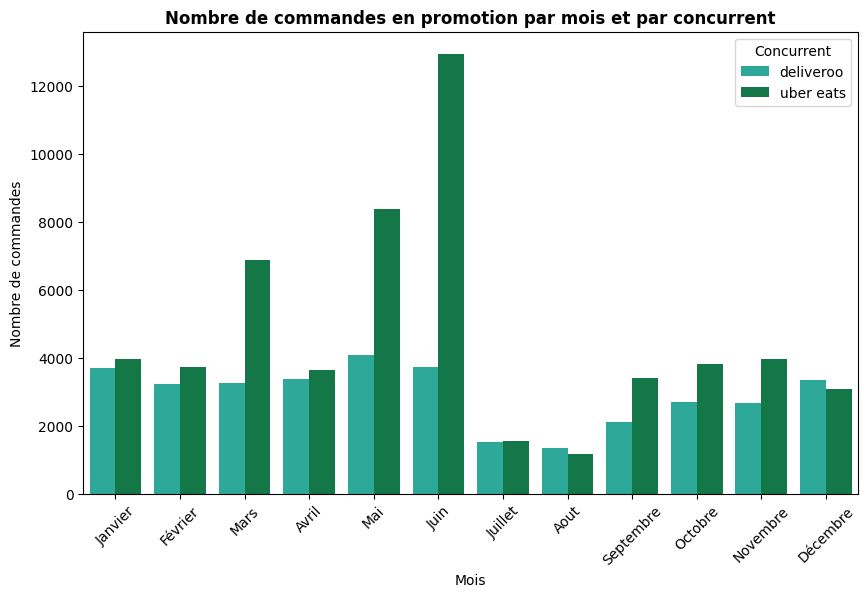

In [275]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=promo_month_comp,
    x='month',
    y='promo',
    hue='merchant_name',
    errorbar=None,
    palette=palette
)
plt.title('Nombre de commandes en promotion par mois et par concurrent', fontsize=12, fontweight='bold')
plt.xlabel('Mois')
plt.ylabel('Nombre de commandes')
plt.xticks(rotation=45)
plt.legend(title='Concurrent')
plt.show()

In [276]:
# Analyse des promotions par jour de la semaine
day_of_week_promo = df_transactions_no_just_eat.groupby(df_transactions_no_just_eat['order_datetime'].dt.day_name())['order_total'].count().reset_index().rename(columns={'order_datetime': 'day_of_week'})
day_of_week_promo['promo'] = df_transactions_no_just_eat[df_transactions_no_just_eat['is_promo']].groupby(df_transactions_no_just_eat['order_datetime'].dt.day_name())['order_total'].count().reset_index(drop=True)
day_of_week_promo['no_promo'] = df_transactions_no_just_eat[~df_transactions_no_just_eat['is_promo']].groupby(df_transactions_no_just_eat['order_datetime'].dt.day_name())['order_total'].count().reset_index(drop=True)
day_of_week_promo = day_of_week_promo.set_index('day_of_week').reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).reset_index()
day_of_week_promo['day_of_week'] = day_of_week_promo['day_of_week'].replace({
    'Monday': 'Lundi',
    'Tuesday': 'Mardi',
    'Wednesday': 'Mercredi',
    'Thursday': 'Jeudi',
    'Friday': 'Vendredi',
    'Saturday': 'Samedi',
    'Sunday': 'Dimanche'
})
display(day_of_week_promo)

,day_of_week,order_total,promo,no_promo
0,Lundi,86358,10635,75723
1,Mardi,89032,11151,77881
2,Mercredi,94099,12276,81823
3,Jeudi,97725,12677,85048
4,Vendredi,108502,14942,93560
5,Samedi,104004,13815,90189
6,Dimanche,124035,16161,107874


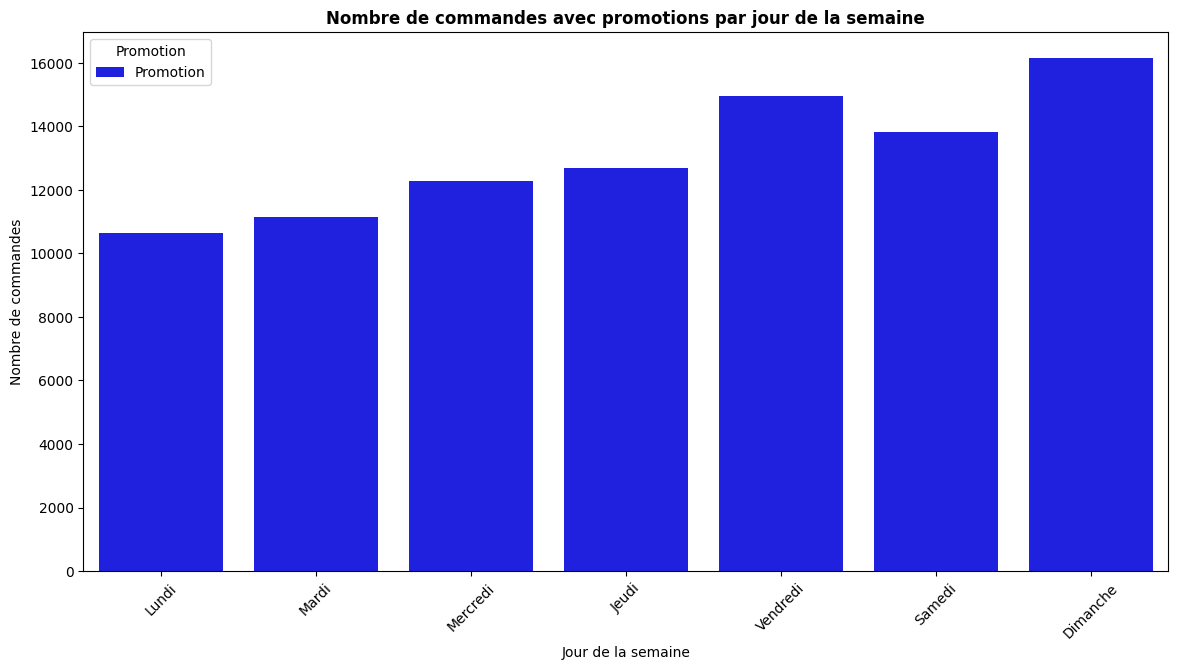

In [277]:
plt.figure(figsize=(14, 7))
sns.barplot(data=day_of_week_promo, x='day_of_week', y='promo', color='blue', label='Promotion')
plt.title('Nombre de commandes avec promotions par jour de la semaine', fontsize=12, fontweight='bold')
plt.ylabel('Nombre de commandes')
plt.xlabel('Jour de la semaine')
plt.xticks(rotation=45)
plt.legend(title='Promotion')
plt.show()

In [278]:
# Analyse des promotions par mois
month_promo = df_transactions_no_just_eat.groupby(df_transactions_no_just_eat['order_datetime'].dt.month_name())['order_total'].count().reset_index().rename(columns={'order_datetime': 'month'})
month_promo['promo'] = df_transactions_no_just_eat[df_transactions_no_just_eat['is_promo']].groupby(df_transactions_no_just_eat['order_datetime'].dt.month_name())['order_total'].count().reset_index(drop=True)
month_promo['no_promo'] = df_transactions_no_just_eat[~df_transactions_no_just_eat['is_promo']].groupby(df_transactions_no_just_eat['order_datetime'].dt.month_name())['order_total'].count().reset_index(drop=True)
month_promo = month_promo.set_index('month').reindex([      'January',
                                                            'February',
                                                            'March',
                                                            'April',
                                                            'May',
                                                            'June',
                                                            'July',
                                                            'August',
                                                            'September',
                                                            'October',
                                                            'November',
                                                            'December']).reset_index()
month_promo['month'] = month_promo['month'].replace({
                                                    'January': 'Janvier',
                                                    'February': 'Février',
                                                    'March': 'Mars',
                                                    'April': 'Avril',
                                                    'May': 'Mai',
                                                    'June': 'Juin',
                                                    'July': 'Juillet',
                                                    'August': 'Aout',
                                                    'September': 'Septembre',
                                                    'October' : 'Octobre',
                                                    'November': 'Novembre',
                                                    'December': 'Décembre'
                                                    })
display(month_promo)

,month,order_total,promo,no_promo
0,Janvier,66410,7668,58742
1,Février,62686,6945,55741
2,Mars,67006,10127,56879
3,Avril,59580,7028,52552
4,Mai,81876,12485,69391
5,Juin,83731,16693,67038
6,Juillet,37428,3085,34343
7,Aout,34140,2530,31610
8,Septembre,46132,5514,40618
9,Octobre,53014,6522,46492


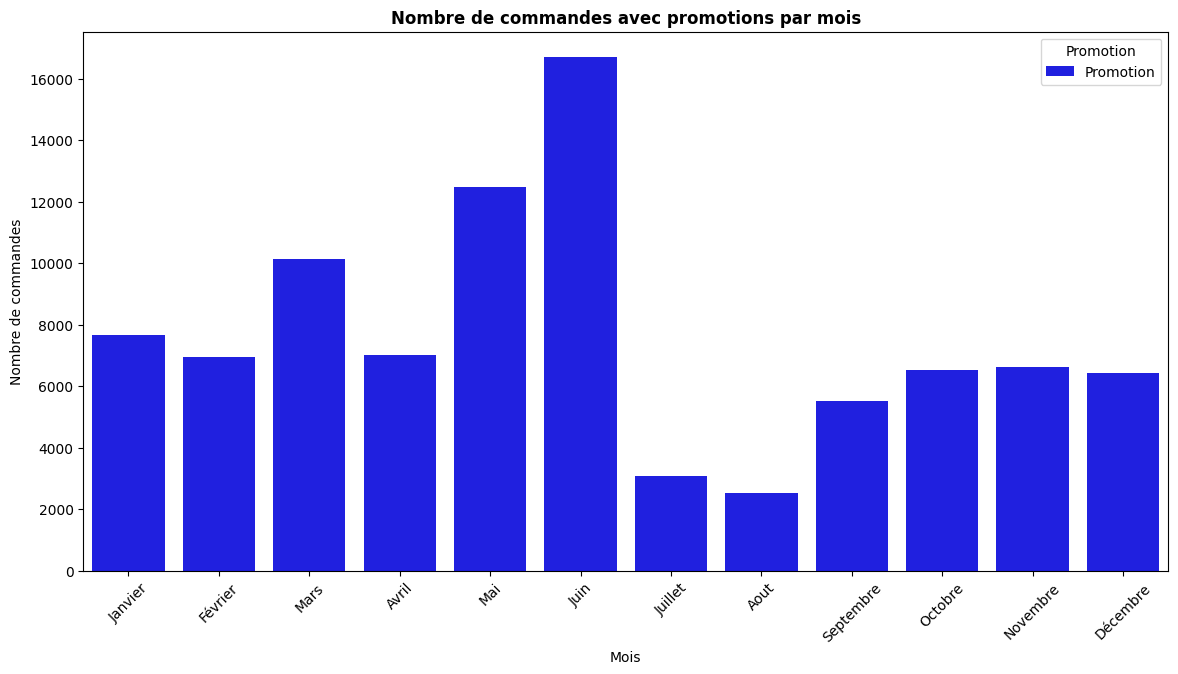

In [279]:
plt.figure(figsize=(14, 7))
sns.barplot(data=month_promo, x='month', y='promo', color='blue', label='Promotion')
plt.title('Nombre de commandes avec promotions par mois', fontsize=12, fontweight='bold')
plt.ylabel('Nombre de commandes')
plt.xlabel('Mois')
plt.xticks(rotation=45)
plt.legend(title='Promotion')
plt.show()

In [280]:
year_promo = df_transactions_no_just_eat.groupby(df_transactions_no_just_eat['order_datetime'].dt.year)['order_total'].count().reset_index().rename(columns={'order_datetime': 'year'})
year_promo['promo'] = df_transactions_no_just_eat[df_transactions_no_just_eat['is_promo']].groupby(df_transactions_no_just_eat['order_datetime'].dt.year)['order_total'].count().reset_index(drop=True)
year_promo['no_promo'] = df_transactions_no_just_eat[~df_transactions_no_just_eat['is_promo']].groupby(df_transactions_no_just_eat['order_datetime'].dt.year)['order_total'].count().reset_index(drop=True)
display(year_promo)

,year,order_total,promo,no_promo
0,2017,62752,7290,55462
1,2018,155825,7849,147976
2,2019,287816,33476,254340
3,2020,197362,43042,154320


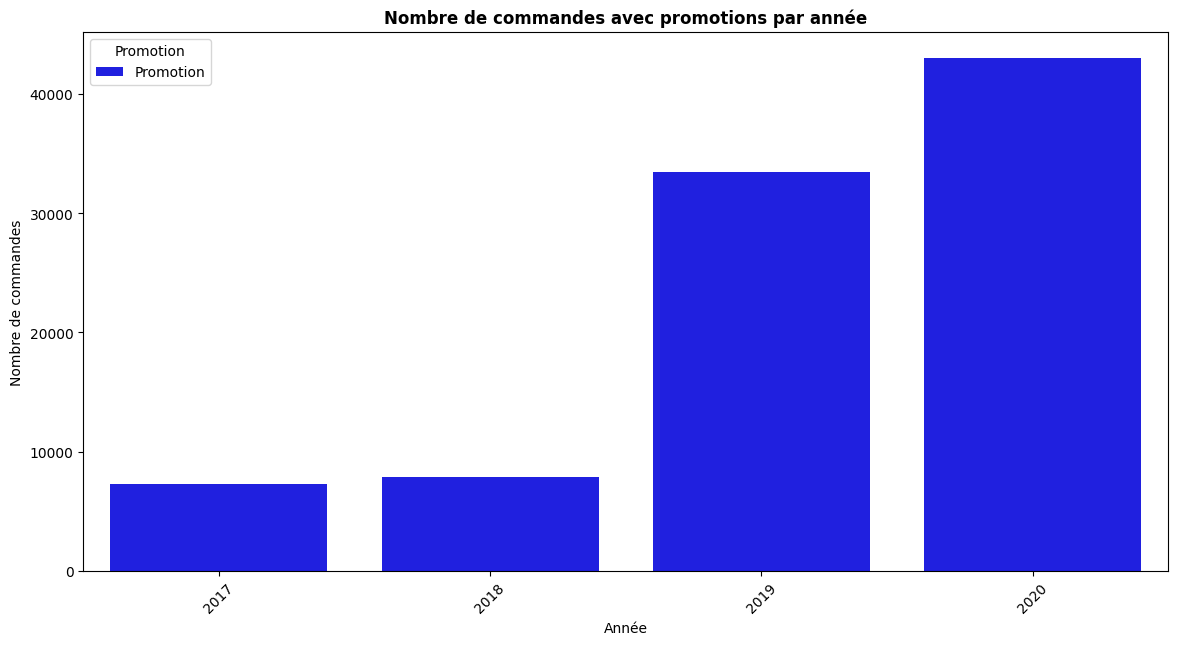

In [281]:
plt.figure(figsize=(14, 7))
sns.barplot(data=year_promo, x='year', y='promo', color='blue', label='Promotion')
plt.title('Nombre de commandes avec promotions par année', fontsize=12, fontweight='bold')
plt.ylabel('Nombre de commandes')
plt.xlabel('Année')
plt.xticks(rotation=45)
plt.legend(title='Promotion')
plt.show()

> Malgré une année 2020 incomplète dans le jeu de données, on remarque que les concurrents ont réalisés beaucoup de promotion en 2020 (pour rappel, le dataframe 'transactions' s'étend du 2017-01-01 00:00:00 au 2020-06-30 23:00:00).

In [282]:
# Impact des promotions sur le panier moyen
average_basket_uber_eats_promo = round(np.mean(df_uber[df_uber['is_promo']]['order_total']), 2)
print(f'Le panier moyen d\'une commande Uber est de : {average_basket_uber_eats} € et {average_basket_uber_eats_promo} € lorsque le client bvénéficie d\'une promotion, soit un gain de {round(average_basket_uber_eats_promo - average_basket_uber_eats , 2)} €')

average_basket_deliveroo_promo = round(np.mean(df_deliveroo[df_deliveroo['is_promo']]['order_total']),2)
print(f'Le panier moyen d\'une commande Deliveroo est de : {average_basket_deliveroo} € et {average_basket_deliveroo_promo} € lorsque le client bénéficie d\'une promotion, soit un gain de {round(average_basket_deliveroo_promo - average_basket_deliveroo , 2)} €')

Le panier moyen d'une commande Uber est de : 23.94 € et 27.15 € lorsque le client bvénéficie d'une promotion, soit un gain de 3.21 €
Le panier moyen d'une commande Deliveroo est de : 25.13 € et 26.74 € lorsque le client bénéficie d'une promotion, soit un gain de 1.61 €


In [283]:
# On regarde les promotions d'Uber Eat par tranches de réduction
df_uber.loc[:, 'promo_group'] = pd.cut(df_uber['pourcentage_promo'], bins=range(0, 101, 20), right=False)
df_uber['promo_group'].value_counts()
group_promo_uber = df_uber.groupby('promo_group', observed=False)['order_total'].count().to_frame().reset_index()
display(group_promo_uber)

<ipython-input-283-e20292e278d6>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,promo_group,order_total
0,"[0, 20)",405326
1,"[20, 40)",23449
2,"[40, 60)",10211
3,"[60, 80)",2367
4,"[80, 100)",1088


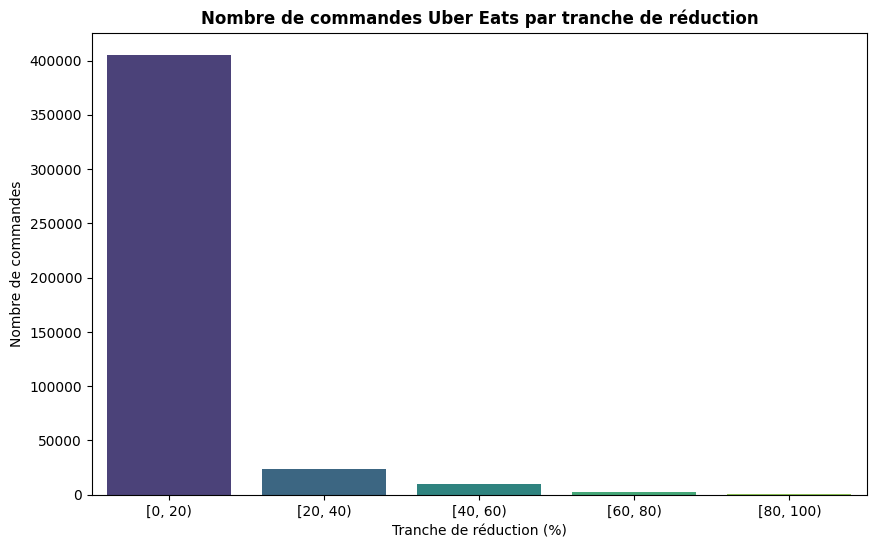

In [284]:
plt.figure(figsize=(10, 6))
sns.barplot(data=group_promo_uber, x='promo_group', y='order_total', hue='promo_group', palette='viridis', legend=False)
plt.title('Nombre de commandes Uber Eats par tranche de réduction', fontsize=12, fontweight='bold')
plt.xlabel('Tranche de réduction (%)')
plt.ylabel('Nombre de commandes')
plt.show()

In [285]:
# On regarde les promotions d'Uber Eat par tranches de réduction
df_deliveroo.loc[:, 'promo_group'] = pd.cut(df_deliveroo['pourcentage_promo'], bins=range(0, 101, 20), right=False)
df_deliveroo['promo_group'].value_counts()
group_promo_deliveroo = df_deliveroo.groupby('promo_group', observed=False)['order_total'].count().to_frame().reset_index()
display(group_promo_deliveroo)

<ipython-input-285-9c385562a6a6>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,promo_group,order_total
0,"[0, 20)",247402
1,"[20, 40)",7046
2,"[40, 60)",2618
3,"[60, 80)",1348
4,"[80, 100)",1449


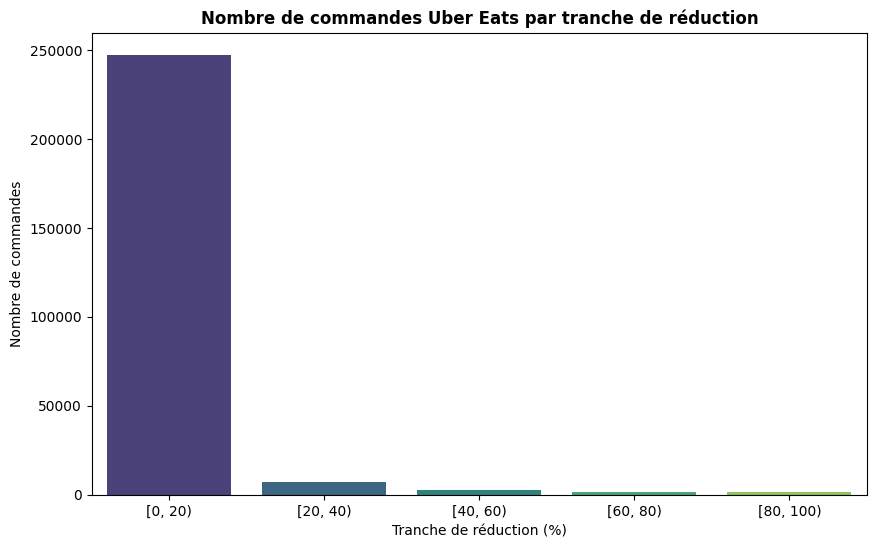

In [286]:
plt.figure(figsize=(10, 6))
sns.barplot(group_promo_deliveroo, x='promo_group', y='order_total', hue='promo_group', palette='viridis', legend=False)
plt.title('Nombre de commandes Uber Eats par tranche de réduction', fontsize=12, fontweight='bold')
plt.xlabel('Tranche de réduction (%)')
plt.ylabel('Nombre de commandes')
plt.show()

In [287]:
# On compare les offres promotionelles des deux concurrents par groupe de réduction
merged_promo_groups = pd.merge(group_promo_deliveroo, group_promo_uber, on='promo_group', suffixes=('_deliveroo', '_uber'))
display(merged_promo_groups)

,promo_group,order_total_deliveroo,order_total_uber
0,"[0, 20)",247402,405326
1,"[20, 40)",7046,23449
2,"[40, 60)",2618,10211
3,"[60, 80)",1348,2367
4,"[80, 100)",1449,1088


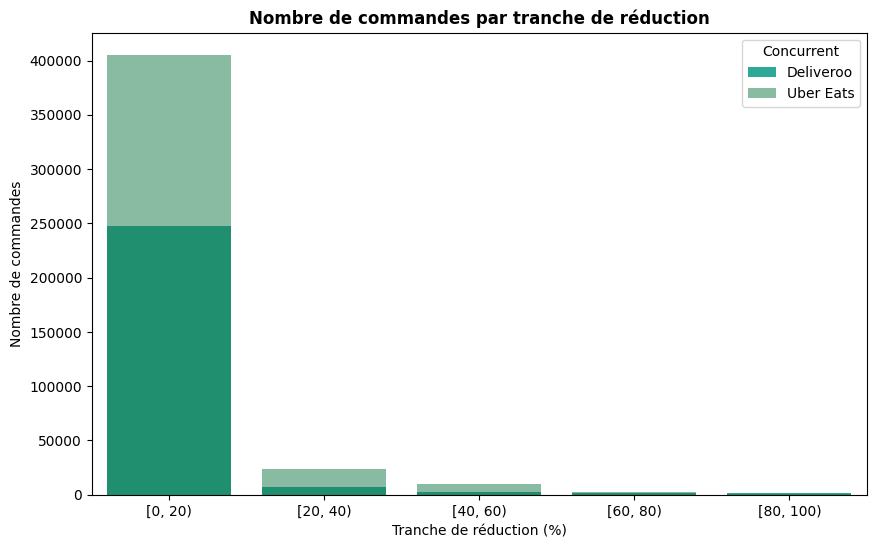

In [288]:
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_promo_groups, x='promo_group', y='order_total_deliveroo', label='Deliveroo', color=palette['deliveroo'])
sns.barplot(data=merged_promo_groups, x='promo_group', y='order_total_uber', label='Uber Eats', color=palette['uber eats'], alpha=0.5)
plt.title('Nombre de commandes par tranche de réduction', fontsize=12, fontweight='bold')
plt.xlabel('Tranche de réduction (%)')
plt.ylabel('Nombre de commandes')
plt.legend(title='Concurrent')
plt.show()


### <a id="fees"></a>Analyse des frais

In [289]:
# Analyse de la composition des frais (traitement, livraison) sur la période
fees_evol = df_transactions_no_just_eat[['order_delivery_fee','order_processing_fee','total_fees']].groupby(df_transactions_no_just_eat['order_datetime'].dt.to_period('M')).sum().reset_index()
fees_evol['merchant_name'] = df_transactions_no_just_eat['merchant_name']
fees_evol['order_datetime'] = fees_evol['order_datetime'].astype(str)

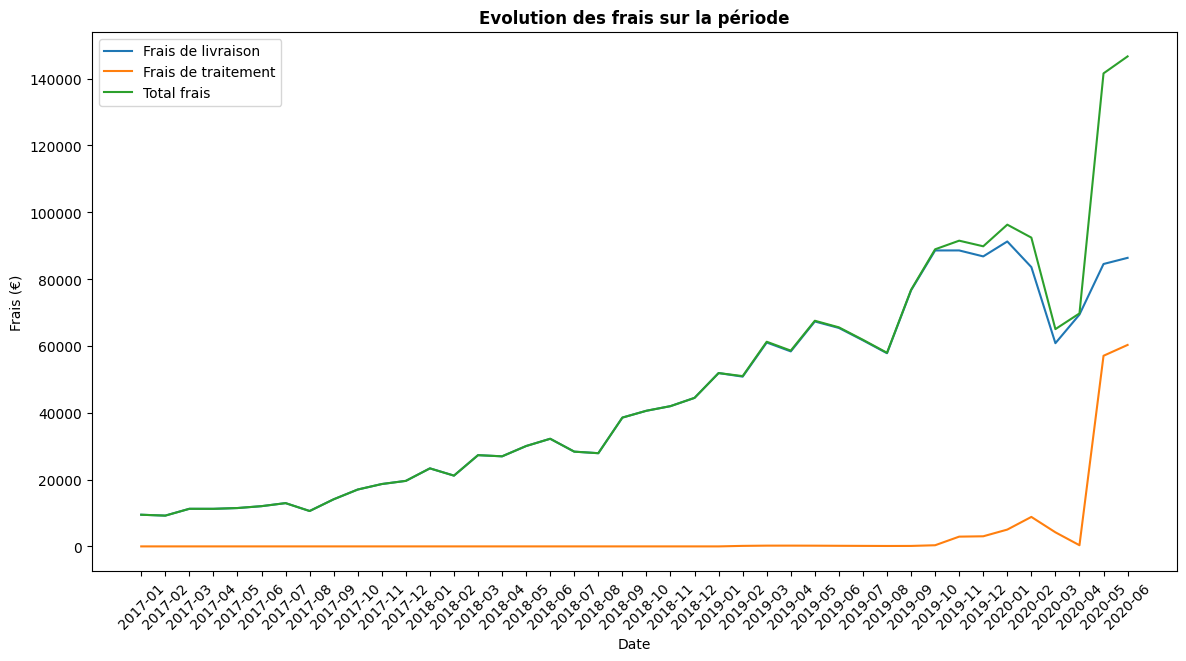

In [290]:
plt.figure(figsize=(14, 7))
plt.plot(fees_evol['order_datetime'], fees_evol['order_delivery_fee'], label='Frais de livraison')
plt.plot(fees_evol['order_datetime'], fees_evol['order_processing_fee'], label='Frais de traitement')
plt.plot(fees_evol['order_datetime'], fees_evol['total_fees'], label='Total frais')
plt.xlabel('Date')
plt.ylabel('Frais (€)')
plt.title('Evolution des frais sur la période', fontsize=12, fontweight='bold')
plt.legend()
plt.xticks(rotation=45)
plt.show()

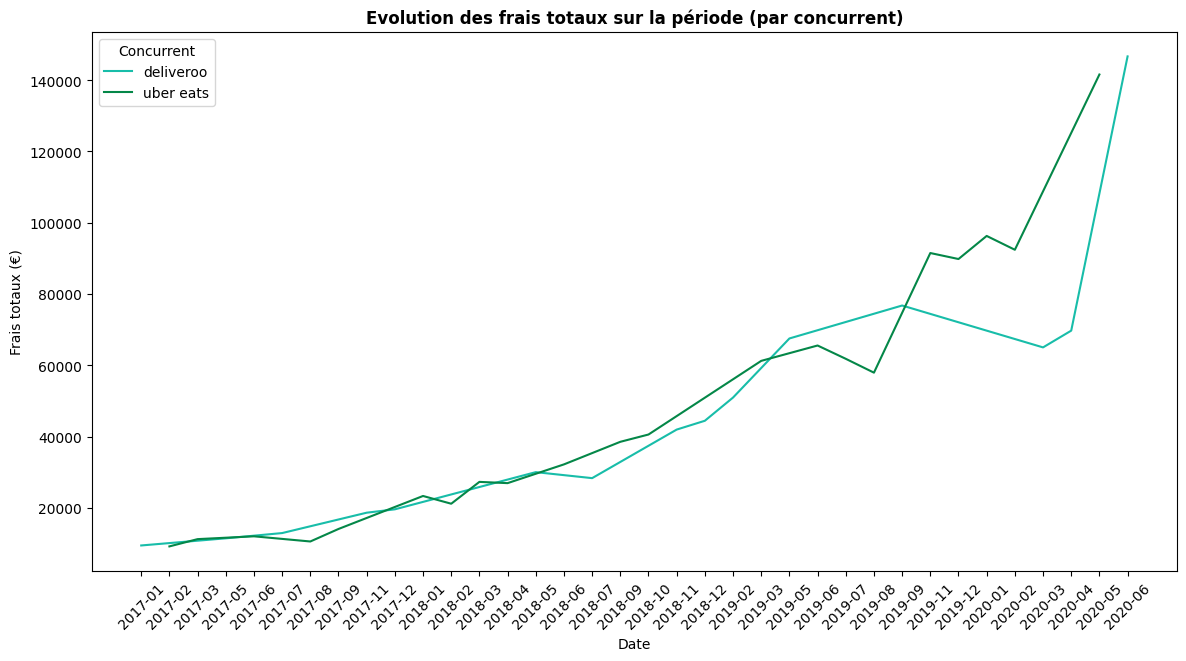

In [291]:
# Analyse des frais totaux par concurrent et par période
fees_evol_merchant = fees_evol.groupby(['order_datetime', 'merchant_name'])[['order_delivery_fee','order_processing_fee','total_fees']].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(data=fees_evol_merchant, x='order_datetime', y='total_fees', hue='merchant_name', palette=palette)
plt.xlabel('Date')
plt.ylabel('Frais totaux (€)')
plt.title('Evolution des frais totaux sur la période (par concurrent)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title='Concurrent')
plt.show()

In [292]:
# A developper :
# Analyse des vendeurs
# Promo par type de produit
# Promo par région ?
# Paniers moyens : avec / sans promotion, par génération ?
# Distribution des montants des commandes vs montant des frais